In [1]:
import pandas as pd
from cryptocmd import CmcScraper


# Other settings
from IPython.display import display, HTML
import os, warnings, logging
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)

class CryptoData:
    """
    The CryptoData class is responsible for fetching and validating cryptocurrency data. 
    It provides methods to fetch raw data, validate its integrity, and format it for display.
    
    Attributes:
    - EXPECTED_COLUMNS: A set of expected columns in the fetched data.
    - crypto_symbols: A list of cryptocurrency symbols to fetch.
    - retries: The maximum number of data fetch retries.
    - backoff_factor: The exponential backoff factor for retries.
    """
    
    EXPECTED_COLUMNS = {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}

    def __init__(self, crypto_symbols: list[str], retries: int = 5, backoff_factor: float = 0.3):
        """Initializes the class with the given list of cryptocurrency symbols."""
        logger.info("Initializing CryptoData class.")
        self.crypto_symbols = crypto_symbols
        self.retries = retries
        self.backoff_factor = backoff_factor
        self.DATA_DIR = "crypto_assets"
        if not os.path.exists(self.DATA_DIR):
            os.makedirs(self.DATA_DIR)
        logger.info("CryptoData class initialized.")

    def _fetch_cryptocmd_data(self, symbol: str) -> pd.DataFrame:
        """Fetches cryptocurrency data with retries and exponential backoff."""
        logger.info(f"Fetching data for {symbol}.")
        scraper = CmcScraper(symbol)
        df = scraper.get_dataframe()

        # Drop unwanted columns
        unwanted_columns = ['Time Open', 'Time High', 'Time Low', 'Time Close']
        df.drop(columns=unwanted_columns, inplace=True)
        
        # Sort data by Date in ascending order
        df.sort_values(by='Date', ascending=True, inplace=True)
        return df

    def _local_data_path(self, symbol: str) -> str:
        return os.path.join(self.DATA_DIR, f"data_c_{symbol}.csv")

    def get_cryptocmd_data(self, symbol: str, overwrite: bool = False) -> pd.DataFrame:
        """Fetches and returns the cryptocurrency data."""
        logger.info(f"Retrieving {symbol} data.")
        df = self._fetch_cryptocmd_data(symbol)
        
        # Save to local storage if needed
        file_path = self._local_data_path(symbol)
        if overwrite or not os.path.exists(file_path):
            df.to_csv(file_path, index=False)
        
        # Set 'Date' as the index
        df.set_index('Date', inplace=True)
        return df

    def get_all_data(self, overwrite: bool = False) -> dict[str, pd.DataFrame]:
        """Fetches data for all specified cryptocurrencies."""
        logger.info("Getting data for all specified cryptocurrencies.")
        data_dict = {}
        for symbol in self.crypto_symbols:
            data_dict[symbol] = self.get_cryptocmd_data(symbol, overwrite)
        logger.info("All data retrieved successfully.")
        return data_dict

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        """Formats a monetary value to a string."""
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        """Formats a volume value to a string."""
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self, symbol: str) -> pd.DataFrame:
        """Formats the cryptocurrency data for display."""
        logger.info(f"Formatting display data for {symbol}.")
        
        # Load the data for the given symbol from local storage
        file_path = self._local_data_path(symbol)
        if not os.path.exists(file_path):
            raise ValueError(f"No data found for {symbol}. Please fetch the data first.")
        display_df = pd.read_csv(file_path, parse_dates=['Date']).set_index('Date')
        
        # Format the data
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)
        volume_like_columns = ['Volume', 'Market Cap']
        display_df[volume_like_columns] = display_df[volume_like_columns].applymap(self._format_volume_value)
        logger.info(f"Display data formatted successfully for {symbol}.")
        return display_df
    
    def get_all_display_data(self) -> pd.DataFrame:
        """Fetches display data for all specified cryptocurrencies and concatenates them into a single DataFrame."""
        logger.info("Getting display data for all specified cryptocurrencies.")
        display_data_list = []
        
        for symbol in self.crypto_symbols:
            display_df = self.get_display_data(symbol)
            display_df['Ticker'] = symbol  # Add a column for the ticker symbol
            display_data_list.append(display_df)
        
        # Concatenate all the DataFrames along the index
        all_display_data = pd.concat(display_data_list, keys=self.crypto_symbols)
        
        logger.info("All display data retrieved successfully.")
        return all_display_data


    
# Part 1 - Data Fetching
def run_data_fetcher(run: bool, tickers: list, get_display_data=False, overwrite=False):
    if not run:
        return None, None  # Return None for all objects if not running
    
    # Fetch the data
    crypto_data_obj = CryptoData(tickers)
    all_data = crypto_data_obj.get_all_data(overwrite=overwrite)
    
    all_display_data = None
    if get_display_data:
        all_display_data = crypto_data_obj.get_all_display_data()
    
    # Return the objects
    return crypto_data_obj, all_data, all_display_data

tickers = ['BTC','ETH','ADA']
crypto_data_obj, all_data, all_display_data = run_data_fetcher(True, tickers, get_display_data=True, overwrite=True)
btc_data = all_data['BTC']
btc_display_data = all_display_data.loc['BTC']

2023-11-02 23:44:21,702 [INFO] - Initializing CryptoData class.
2023-11-02 23:44:21,704 [INFO] - CryptoData class initialized.
2023-11-02 23:44:21,710 [INFO] - Getting data for all specified cryptocurrencies.
2023-11-02 23:44:21,713 [INFO] - Retrieving BTC data.
2023-11-02 23:44:21,718 [INFO] - Fetching data for BTC.
2023-11-02 23:44:24,450 [INFO] - Retrieving ETH data.
2023-11-02 23:44:24,451 [INFO] - Fetching data for ETH.
2023-11-02 23:44:26,638 [INFO] - Retrieving ADA data.
2023-11-02 23:44:26,638 [INFO] - Fetching data for ADA.
2023-11-02 23:44:28,901 [INFO] - All data retrieved successfully.
2023-11-02 23:44:28,902 [INFO] - Getting display data for all specified cryptocurrencies.
2023-11-02 23:44:28,903 [INFO] - Formatting display data for BTC.
2023-11-02 23:44:28,929 [INFO] - Display data formatted successfully for BTC.
2023-11-02 23:44:28,930 [INFO] - Formatting display data for ETH.
2023-11-02 23:44:28,959 [INFO] - Display data formatted successfully for ETH.
2023-11-02 23:44:

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import jarque_bera, kstest
from data_fetcher import btc_data
from pandas import Timestamp

from pandas.tseries.offsets import DateOffset

# Other settings
from IPython.display import display, HTML
import os, warnings, logging
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)

class TimeSeriesAnalysis:
    """
    A class to perform various time series analysis tasks such as stationarity checks, volatility modeling, and decomposition.

    Attributes:
        data (pd.DataFrame): Time series data.
        target (str): Target column for time series analysis.
    """

    def __init__(self, data, target):
        """
        Initialize the TimeSeriesAnalysis class.

        Parameters:
            data (pd.DataFrame): Time series data.
            target (str): Target column for time series analysis.
        """
        logger.info("Initializing TimeSeriesAnalysis class.")
        if target not in data.columns:
            logger.error(f"'{target}' is not a column in the provided data.")
            raise ValueError(f"'{target}' is not a column in the provided data.")
        self.original_data = data.copy()
        self.data = data
        self.target = target
        self.alpha = 0.05
        logger.info("TimeSeriesAnalysis class initialized successfully.")


    def test_granger_causality(self, other_column, maxlag=30, verbose=False):
        """Test Granger Causality between target and another time series column.
        
        Parameters:
            other_column (str): The name of the other column to test for Granger Causality.
            maxlag (int): The maximum number of lags to consider for the test.
            verbose (bool): Whether to display detailed output.
        
        Returns:
            dict: A dictionary containing the Granger Causality test results.
        """
        logger.info(f"Testing Granger causality between '{self.target}' and '{other_column}' with maxlag={maxlag}.")
        if other_column not in self.data.columns:
            logger.error(f"'{other_column}' is not a column in the provided data.")
            raise ValueError(f"'{other_column}' is not a column in the provided data.")
        other_data = self.data[other_column].values
        target_data = self.data[self.target].values
        data = np.column_stack((target_data, other_data))
        result = grangercausalitytests(data, maxlag=maxlag, verbose=verbose)
        logger.info("Granger causality test completed.")
        return result
    
    def concise_granger_output_table(self, granger_results):
        """Generate a concise report from the Granger Causality test results in a table format."""
        logger.info("Generating concise Granger causality output table.")
        table_content = ['<table border="1" style="border-collapse:collapse;">']
        lags = list(granger_results.keys())
        for i in range(0, len(lags), 6):
            table_content.append('<tr>')
            for j in range(6):
                if i + j < len(lags):
                    lag = lags[i + j]
                    test_statistics = granger_results[lag][0]
                    cell_content = (f"<b>Lag: {lag}</b><br>"
                                    f"ssr_ftest: F={test_statistics['ssr_ftest'][0]:.4f}, p={test_statistics['ssr_ftest'][1]:.4f}<br>"
                                    f"ssr_chi2test: chi2={test_statistics['ssr_chi2test'][0]:.4f}, p={test_statistics['ssr_chi2test'][1]:.4f}<br>"
                                    f"lrtest: chi2={test_statistics['lrtest'][0]:.4f}, p={test_statistics['lrtest'][1]:.4f}<br>"
                                    f"params_ftest: F={test_statistics['params_ftest'][0]:.4f}, p={test_statistics['params_ftest'][1]:.4f}")
                    table_content.append(f'<td style="padding: 8px; text-align: left;">{cell_content}</td>')
            table_content.append('</tr>')
        table_content.append('</table>')
        logger.info("Concise Granger causality output table generated.")
        return "\n".join(table_content)
    
    def save_and_show_plot(self, fig, filename, show=True):
        """
        Utility method to save and display the plot.

        Parameters:
            fig (matplotlib.figure.Figure): The plot figure.
            filename (str): Filename to save the plot.
            show (bool, optional): Whether to display the plot. Default is True.
        """
        logger.info(f"Saving plot to '{filename}' and displaying plot: {show}.")
        if not os.path.exists('ts_plots_assets'):
            os.makedirs('ts_plots_assets')
        path = os.path.join('ts_plots_assets', filename)
        fig.savefig(path)
        if show:
            plt.show()
        logger.info(f"Plot '{filename}' saved and {'shown' if show else 'not shown'}.")

    def check_autocorrelation(self, lags=25, alpha=0.05, show=True):
        """
        Check the autocorrelation of the time series using ACF and PACF plots.
        Parameters:
            lags (int): Number of lags to consider. Default is 25.
            alpha (float): Significance level for the confidence interval. Default is 0.05.
            show_plot (bool): Whether to display the plot.
        """
        logger.info(f"Checking autocorrelation for '{self.target}' with {lags} lags.")
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
            plot_acf(self.data[self.target], lags=lags, alpha=alpha, ax=ax1)
            ax1.set_title(f"ACF for {self.target}")
            plot_pacf(self.data[self.target], lags=lags, alpha=alpha, method='ols', ax=ax2)
            ax2.set_title(f"PACF for {self.target}")
            self.save_and_show_plot(fig, 'autocorrelation.png', show=show)
            logger.info("Autocorrelation check completed successfully.")
            return fig
        except Exception as e:
            logger.error(f"Error checking autocorrelation: {e}")
            raise

    def estimate_seasonal_period(self, max_lag=100):
        """
        Estimate the seasonal period of the data using autocorrelation and partial autocorrelation.

        Parameters:
            max_lag (int): The maximum lag to which the ACF and PACF are computed.

        Returns:
            int or None: Estimated seasonal period, or None if no clear seasonality is found.
        """
        logger.info(f"Starting estimation of seasonal period for '{self.target}' with a maximum lag of {max_lag}.")
        data = self.data[self.target]  # Use the target column from the instance's data
        acf_vals = acf(data, nlags=max_lag)
        pacf_vals = pacf(data, nlags=max_lag, method='ols')

        seasonal_lag_acf = np.argmax(acf_vals)
        significant_pacf_lags = np.where(pacf_vals > 1.96 / np.sqrt(len(data)))[0]

        if not significant_pacf_lags.size:
            logger.info("No significant PACF peak found; difficult to estimate seasonality.")
            return None

        if acf_vals[seasonal_lag_acf] < 0.2:  # This threshold is arbitrary and can be adjusted
            logger.info("ACF value at estimated period is low; seasonality may not be significant.")
            return None

        estimated_period = min(seasonal_lag_acf, min(significant_pacf_lags))
        logger.info(f"Estimated seasonal period is {estimated_period}.")
        return estimated_period

    def decompose_time_series(self, model='additive', period=None, show=True):
        """
        Decompose the time series data into trend, seasonal, and residual components.
    
        Parameters:
            model (str): The type of decomposition model ('additive' or 'multiplicative').
            period (int): The period for seasonal decomposition. Must be provided by the user.
            show_plot (bool): Whether to display the plot of the decomposed components.
        
        Returns:
            dict: A dictionary containing the decomposed components 'trend', 'seasonal', and 'residual'.
        """
        if period is None:
            raise ValueError("Period for seasonal decomposition must be provided.")

        # Perform the decomposition
        decomposition_result = seasonal_decompose(self.data[self.target], model=model, period=period)

        # Plotting the decomposed components
        if show:
            fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
            decomposition_result.observed.plot(ax=axes[0], title='Observed')
            decomposition_result.trend.plot(ax=axes[1], title='Trend')
            decomposition_result.seasonal.plot(ax=axes[2], title='Seasonal')
            decomposition_result.resid.plot(ax=axes[3], title='Residual')
            plt.tight_layout()
            plt.show()

        # Returning the components
        return {
            'observed': decomposition_result.observed,
            'trend': decomposition_result.trend,
            'seasonal': decomposition_result.seasonal,
            'residual': decomposition_result.resid
        }















    def analyze_decomposition(self, decomposition_result):
        """
        Analyze the time series decomposition results and provide guidance.
    
        Parameters:
            decomposition_result (DecomposeResult): The result from seasonal decomposition.
    
        Returns:
            str: Guidance based on the decomposition results.
        """
        guidance = ""
        
        # Analyzing the trend component
        if decomposition_result.trend.isnull().sum() > 0:
            guidance += "The trend component has missing values at the boundaries. Consider using a different decomposition method or filling the missing values.\n"
        else:
            trend_strength = np.nanmean(np.abs(decomposition_result.trend - np.nanmean(decomposition_result.trend)))
            if trend_strength > 0.05 * np.nanmean(decomposition_result.observed):
                guidance += "The trend component is strong. Consider detrending the series if you intend to use models that assume stationarity.\n"
            else:
                guidance += "The trend component is weak, indicating a relatively stable mean over time.\n"
                
        # Analyzing the seasonal component
        seasonal_strength = np.nanmean(np.abs(decomposition_result.seasonal - np.nanmean(decomposition_result.seasonal)))
        if seasonal_strength > 0.05 * np.nanmean(decomposition_result.observed):
            guidance += "The seasonal component is strong. Consider seasonal adjustment or using models that can handle seasonality.\n"
        else:
            guidance += "The seasonal component is weak, indicating that seasonality may not be a significant factor.\n"
            
        # Analyzing the residual component
        if decomposition_result.resid.isnull().sum() > 0:
            guidance += "The residual component has missing values at the boundaries. Consider using a different decomposition method or filling the missing values.\n"
        else:
            if np.nanstd(decomposition_result.resid) > 0.05 * np.nanmean(decomposition_result.observed):
                guidance += "The residual component shows variability. Consider further analysis to identify any remaining patterns or anomalies.\n"
            else:
                guidance += "The residual component is relatively stable, indicating that most of the patterns have been captured by the trend and seasonal components.\n"
                
        return guidance



    def diagnostic_check(self, alpha=None, return_stationarity=False):
        alpha = alpha if alpha is not None else self.alpha
        
        # Augmented Dickey-Fuller test
        adf_result = adfuller(self.data[self.target])
        if adf_result[1] <= alpha:
            adf_conclusion = "The time series appears to be stationary based on the ADF test."
            adf_guidance = "You might not need to difference the time series. However, consider checking other diagnostics and plots to confirm."
        else:
            adf_conclusion = "The time series appears to be non-stationary based on the ADF test. Differencing might be needed to make it stationary."
            adf_guidance = "Consider applying differencing or transformation to achieve stationarity."
        
        # Jarque-Bera test
        jb_value, p_value = jarque_bera(self.data[self.target])
        if p_value > alpha:
            jb_conclusion = "The time series seems to follow a normal distribution based on the Jarque-Bera test."
            jb_guidance = "The normality assumption holds. This is good if you plan to use models that assume normally distributed residuals."
        else:
            jb_conclusion = "The time series does not appear to be normally distributed based on the Jarque-Bera test."
            jb_guidance = "Consider transforming the series or using models that do not assume normality."
        
        # KPSS test
        kpss_value, kpss_p_value, _, kpss_crit = kpss(self.data[self.target])
        if kpss_p_value > alpha:
            kpss_conclusion = "The time series appears to be stationary around a constant or trend based on the KPSS test."
            kpss_guidance = "The series might be stationary. However, consider other diagnostics to confirm."
        else:
            kpss_conclusion = "The time series appears to be non-stationary based on the KPSS test. It might have a unit root."
            kpss_guidance = "Consider differencing or detrending the series to achieve stationarity."
        
        # Kolmogorov-Smirnov test
        ks_value, ks_p_value = kstest(self.data[self.target], 'norm')
        if ks_p_value > alpha:
            ks_conclusion = "The time series appears to follow a normal distribution based on the Kolmogorov-Smirnov test."
            ks_guidance = "The normality assumption holds, which is beneficial for certain statistical models."
        else:
            ks_conclusion = "The time series does not seem to follow a normal distribution based on the Kolmogorov-Smirnov test."
            ks_guidance = "Consider transforming the series or using models that do not assume normality."
    
        # Create the results dictionary
        results = {
            'ADF': {
                'Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Critical Values': adf_result[4],
                'Conclusion': adf_conclusion,
                'Guidance': adf_guidance
            },
            'Jarque-Bera': {
                'Statistic': jb_value,
                'p-value': p_value,
                'Conclusion': jb_conclusion,
                'Guidance': jb_guidance
            },
            'KPSS': {
                'Statistic': kpss_value,
                'p-value': kpss_p_value,
                'Critical Values': kpss_crit,
                'Conclusion': kpss_conclusion,
                'Guidance': kpss_guidance
            },
            'Kolmogorov-Smirnov': {
                'Statistic': ks_value,
                'p-value': ks_p_value,
                'Conclusion': ks_conclusion,
                'Guidance': ks_guidance
            }
        }
    
        # Check for Seasonality using ACF
        lag_acf = acf(self.data[self.target], nlags=40)
        lag_pacf = pacf(self.data[self.target], nlags=40, method='ols')
    
        # If there are significant peaks at regular intervals in ACF, we can suspect seasonality
        seasonality_conclusion = "Seasonality is likely present in the time series." if any(lag_acf > 0.2) else "Seasonality is likely not present in the time series."
    
        # Now, update the results dictionary with the seasonality check
        results['Seasonality'] = {
            'Conclusion': seasonality_conclusion
        }
    
        # Determine stationarity based on the tests
        is_stationary = adf_result[1] <= alpha and kpss_p_value > alpha
    
        # Output or return results based on return_stationarity
        if return_stationarity:
            return is_stationary
        else:
            # Output to console
            for test, result in results.items():
                print(f"--- {test} ---")
                for key, value in result.items():
                    print(f"{key}: {value}")
                print("\n")
            return None

    def auto_stationary(self, seasonal_period=None, alpha=0.05):
        """
        Automatically choose the best method to make the series stationary based on its characteristics.

        Parameters:
            seasonal_period (int, optional): The period of the seasonality, used for seasonal differencing.
            alpha (float, optional): Significance level for the stationarity tests. Default is 0.05.

        Returns:
            pd.Series: The transformed time series, or the original series if no transformation made it stationary.
        """
        original_series = self.data[self.target].copy()  # Make a copy of the original series

        # Check for stationarity
        if self.diagnostic_check(alpha=alpha, return_stationarity=True):
            print("The series is already stationary.")
            return original_series  # Explicitly return the original series

        # Try differencing
        diff_series = original_series.diff().dropna()
        if self.diagnostic_check(alpha=alpha, return_stationarity=True):
            print("Differencing made the series stationary.")
            return diff_series

        # Try log transformation if all values are positive
        if (original_series <= 0).any():
            print("Series contains non-positive values, cannot apply log transformation.")
        else:
            log_series = np.log(original_series).dropna()
            if self.diagnostic_check(alpha=alpha, return_stationarity=True):
                print("Log transformation made the series stationary.")
                return log_series

        # Try square root transformation
        sqrt_series = np.sqrt(original_series).dropna()
        if self.diagnostic_check(alpha=alpha, return_stationarity=True):
            print("Square root transformation made the series stationary.")
            return sqrt_series

        # If seasonal_period is provided, try seasonal differencing
        if seasonal_period is not None:
            seasonal_diff_series = original_series.diff(seasonal_period).dropna()
            if self.diagnostic_check(alpha=alpha, return_stationarity=True):
                print("Seasonal differencing made the series stationary.")
                return seasonal_diff_series

        print("Could not make the series stationary with the tried transformations.")
        return original_series  # Explicitly return the original series

    def make_stationary(self, method='auto', seasonal_period=None):
        """
        Make the time series stationary.
    
        Parameters:
            method (str): The method used to make the series stationary. Options are 'diff' (differencing), 
                          'seasonal_diff' (seasonal differencing), 'log' (log transformation), 'sqrt' (square root transformation),
                          and 'auto' (automatically choose the best method).
            seasonal_period (int, optional): The period of the seasonality, used for seasonal differencing.
    
        Returns:
            pd.Series: The transformed time series.
        """
        if method == 'auto':
            # Providing recommendations based on the characteristics of the time series
            return self.auto_stationary(seasonal_period)
        elif method == 'diff':
            return self.data[self.target].diff().dropna()
        elif method == 'seasonal_diff' and seasonal_period:
            return self.data[self.target].diff(seasonal_period).dropna()
        elif method == 'log':
            return np.log(self.data[self.target]).dropna()
        elif method == 'sqrt':
            return np.sqrt(self.data[self.target]).dropna()
        else:
            raise ValueError("Invalid method or missing seasonal_period for seasonal differencing.")
    
    def visualize_stationarity(self, show_plot=True):
        """
        Visualize the series before and after making it stationary.

        Parameters:
            show_plot (bool): Whether to display the plot.
        
        Returns:
            matplotlib.Figure: The generated figure.
        """
        fig, ax = plt.subplots(2, 1, figsize=(15, 10))

        # Plot original data
        self.original_data[self.target].plot(ax=ax[0], title='Original Series', color='blue')
        
        # Plot transformed data
        self.data[self.target].plot(ax=ax[1], title='Transformed Series', color='green')
        
        plt.tight_layout()
        self.save_and_show_plot(fig, 'stationarity_comparison.png', show=show_plot)
        
        return fig
    
from statsmodels.tsa.stattools import acf, pacf



2023-11-05 18:26:10,074 [INFO] - Initializing TimeSeriesAnalysis class.
2023-11-05 18:26:10,077 [INFO] - TimeSeriesAnalysis class initialized successfully.
2023-11-05 18:26:10,079 [INFO] - Starting estimation of seasonal period for 'Close' with a maximum lag of 100.
2023-11-05 18:26:10,643 [INFO] - Estimated seasonal period is 0.


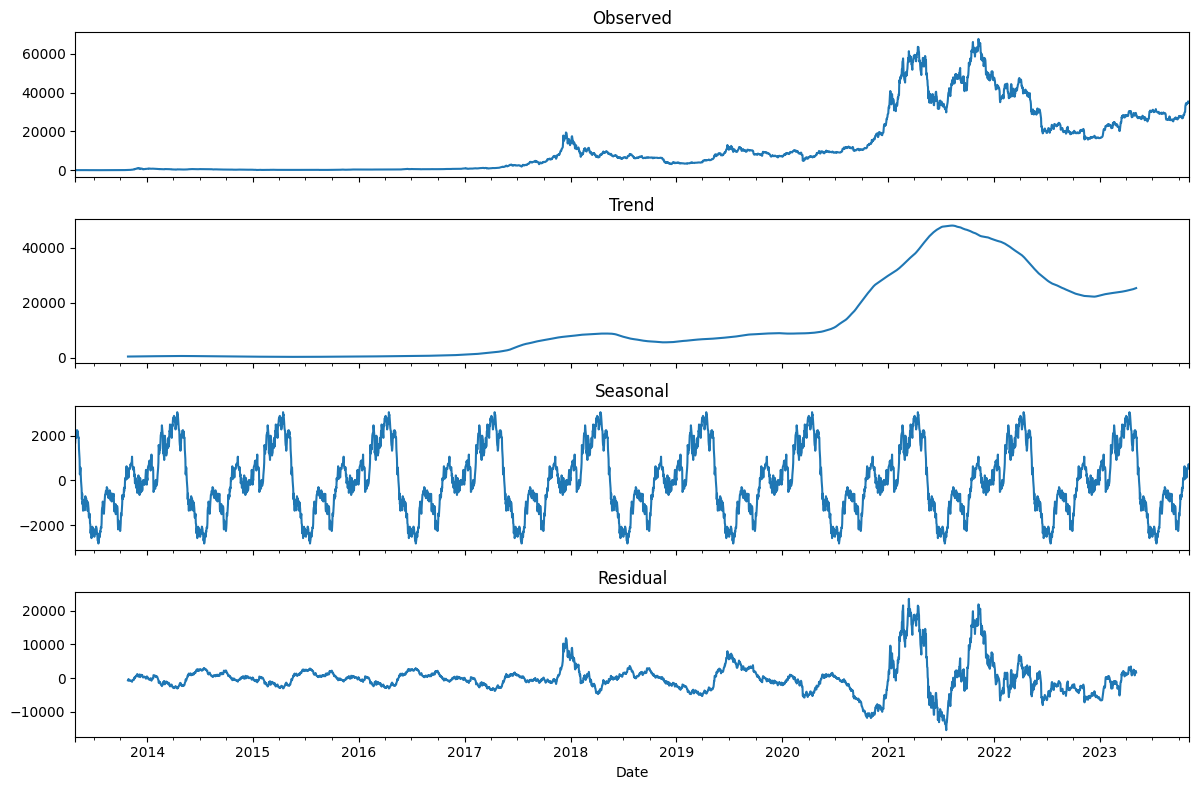

In [58]:
tsa = TimeSeriesAnalysis(btc_data, target='Close')
#granger_results = tsa.test_granger_causality('Open', maxlag=30, verbose=False)
#display(HTML(tsa.concise_granger_output_table(granger_results)))
#autocorr_fig = tsa.check_autocorrelation(lags=35)
estimated_period = tsa.estimate_seasonal_period()
decomposition = tsa.decompose_time_series2(model='additive', period=365, show=True)

In [ ]:
tsa = TimeSeriesAnalysis(btc_data, target='Close')
print("Diagnostics for Original Series:")
original_diagnostics = tsa.diagnostic_check()
    # Make the series stationary and update the data attribute
stationary_series = tsa.make_stationary(method='log')
tsa.data[tsa.target] = stationary_series

tsa.visualize_stationarity(show_plot=True)
    # Create a new instance with the stationary series
tsa_stationary = TimeSeriesAnalysis(pd.DataFrame({tsa.target: stationary_series}), target=tsa.target)
print("\nDiagnostics for Stationary Series:")
stationary_diagnostics = tsa_stationary.diagnostic_check()

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import List, Optional
from typing import Optional, List, Tuple
from scipy.stats import boxcox

class UnifiedDataPreprocessor:
    """ 
    UnifiedDataPreprocessor is responsible for preprocessing time series data.
    It performs actions like data splitting, normalization, reshaping, and sequence generation.
    
    Attributes:
        data (pd.DataFrame): Original time series data.
        target_column (str): Target column for preprocessing.
        logger (logging.Logger): Logger for tracking operations and debugging.
        transformations (list): List of applied transformations.
    """
    
    def __init__(self, df, target_column, logger=None):
        self.data = df.copy()
        self.target_column = target_column
        self.scalers = {}
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.X_train_seq, self.X_test_seq, self.y_train_seq, self.y_test_seq = None, None, None, None
        self.logger = logger if logger else logging.getLogger(__name__)
        self.transformations = []
        self.lambda_val = None  
        self.scalers = {
            "MinMax": MinMaxScaler(),
            "Standard": StandardScaler(),
            "Robust": RobustScaler(),
            "Quantile": QuantileTransformer(output_distribution='normal'),
            "Power": PowerTransformer(method='yeo-johnson')
        }
        self.logger.info("Initializing DataPreprocessor...")        
    
    def get_scaler(self, scaler_type: str):
        self.logger.info(f"Getting scaler of type: {scaler_type}")
        try:
            return self.scalers[scaler_type]
        except KeyError:
            raise ValueError(f"Invalid scaler_type. Supported types are: {', '.join(self.scalers.keys())}")

    def split_and_plot_data(self, test_size: float = 0.2, split_date: Optional[str] = None, plot: bool = True):
        self.logger.info("Splitting data...")
        self.transformations.append('Data Splitting')
        features = self.data.drop(columns=[self.target_column])
        target = self.data[self.target_column]

        if split_date:
            train_mask = self.data.index < split_date
            self.X_train, self.X_test = features[train_mask], features[~train_mask]
            self.y_train, self.y_test = target[train_mask], target[~train_mask]
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                features, target, test_size=test_size, shuffle=False
            )

        self.logger.info(f"Data split completed. X_train shape: {self.X_train.shape}, y_train shape: {self.y_train.shape}")

        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Training Data - Target')
            plt.plot(self.y_train, label=self.target_column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Test Data - Target')
            plt.plot(self.y_test, label=self.target_column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()

    def normalize_data(self, scaler_type: str = 'MinMax', plot: bool = True):
        self.logger.info("Normalizing feature data...")
        scaler = self.get_scaler(scaler_type)
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)
        self.scalers['features'] = scaler
        self.logger.info("Feature data normalization completed.")
        self.transformations.append(f"Feature normalization with {scaler_type} scaler")

        if plot:
            plt.figure(figsize=(20, 8))
            plt.subplot(1, 2, 1)
            plt.title('Normalized Training Features')
            for i in range(self.X_train.shape[1]):
                plt.plot(self.X_train[:, i], label=f'Feature {i}')
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Normalized Test Features')
            for i in range(self.X_test.shape[1]):
                plt.plot(self.X_test[:, i], label=f'Feature {i}')
            plt.legend()
            plt.show()

    def normalize_target(self, scaler_type: str = 'MinMax', plot: bool = True):
        self.logger.info("Normalizing target data...")
        scaler = self.get_scaler(scaler_type)
        self.y_train = scaler.fit_transform(self.y_train.values.reshape(-1, 1))
        self.y_test = scaler.transform(self.y_test.values.reshape(-1, 1))
        self.scalers['target'] = scaler
        self.logger.info("Target data normalization completed.")
        self.transformations.append(f"Target normalization with {scaler_type} scaler")

        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Normalized Training Target')
            plt.plot(self.y_train, label='Normalized ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Normalized Test Target')
            plt.plot(self.y_test, label='Normalized ' + self.target_column)
            plt.legend()
            plt.show()

    def difference_and_plot_data(self, interval: int = 1, plot: bool = True):
        self.logger.info(f"Applying differencing with interval {interval}...")
        self.data = self.data.diff(periods=interval).dropna()
        self.transformations.append(f'Differencing with interval {interval}')
        self.logger.info("Differencing applied.")
        
        if plot:
            plt.figure(figsize=(20, 7))
            plt.title('Data after Differencing')
            plt.plot(self.data[self.target_column], label=self.target_column)
            plt.legend()
            plt.show()

    def box_cox_transform_and_plot(self, lambda_val: Optional[float] = None, plot: bool = True):
        if self.y_train is None or self.y_test is None:
            self.logger.warning("Data not split yet. Run split_data first.")
            return self  # Allow method chaining

        if np.any(self.y_train <= 0) or np.any(self.y_test <= 0):
            self.logger.warning("Data must be positive for Box-Cox transformation.")
            return self  # Allow method chaining

        self.logger.info("Applying Box-Cox transformation...")
        self.y_train = self.y_train.ravel()
        self.y_test = self.y_test.ravel()
        self.y_train, fitted_lambda = boxcox(self.y_train)
        self.lambda_val = fitted_lambda if lambda_val is None else lambda_val
        self.y_test = boxcox(self.y_test, lmbda=self.lambda_val)
        self.transformations.append(f"Box-Cox transformation with lambda {self.lambda_val}")
        self.logger.info(f"Box-Cox transformation applied with lambda {self.lambda_val}.")

        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Box-Cox Transformed Training Target')
            plt.plot(self.y_train, label='Transformed ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Box-Cox Transformed Test Target')
            plt.plot(self.y_test, label='Transformed ' + self.target_column)
            plt.legend()
            plt.show()

    def inverse_box_cox_and_plot(self, plot: bool = True):
        if "Box-Cox transformation" not in "".join(self.transformations):
            self.logger.warning("No Box-Cox transformation found on the target column. Skipping inverse transformation.")
            return

        self.logger.info("Applying inverse Box-Cox transformation...")
        self.y_train = invboxcox(self.y_train, self.lambda_val)
        self.y_test = invboxcox(self.y_test, self.lambda_val)
        self.transformations.remove(f"Box-Cox transformation with lambda {self.lambda_val}")
        self.logger.info(f"Inverse Box-Cox transformation applied on column {self.target_column}.")
        
        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Inverse Box-Cox Transformed Training Target')
            plt.plot(self.y_train, label='Inverse Transformed ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Inverse Box-Cox Transformed Test Target')
            plt.plot(self.y_test, label='Inverse Transformed ' + self.target_column)
            plt.legend()
            plt.show()

    def reshape_for_recurrent(self, data: np.array) -> np.array:
        self.logger.info("Reshaping data for recurrent models...")
        reshaped_data = data.reshape(data.shape)
        self.logger.info(f"Data reshaped to {reshaped_data.shape}.")
        self.transformations.append('Data Reshaped')
        return reshaped_data

    def generate_sequences(self, X_data: np.array, y_data: np.array, n_steps: int, seq_to_seq: bool = False) -> Tuple[np.array, np.array]:
        X, y = [], []
        for i in range(len(X_data) - n_steps):
            seq_x = X_data[i:i + n_steps, :]
            if seq_to_seq:
                seq_y = y_data[i:i + n_steps, :]
            else:
                seq_y = y_data[i + n_steps - 1]
            X.append(seq_x)
            y.append(seq_y)
        self.logger.info(f"Generated {len(X)} sequences of shape {X[0].shape}.")
        self.transformations.append('Sequences Generated')
        return np.array(X), np.array(y)
    
    def prepare_data_for_recurrent(self, n_steps: int, seq_to_seq: bool = False) -> Tuple[np.array, np.array, np.array, np.array]:
        self.logger.info(f"Preparing data for recurrent models with {n_steps} timesteps...")
        X_train_seq, y_train_seq = self.generate_sequences(self.X_train, self.y_train, n_steps, seq_to_seq)
        X_test_seq, y_test_seq = self.generate_sequences(self.X_test, self.y_test, n_steps, seq_to_seq)

        # Update instance variables here
        self.X_train_seq = self.reshape_for_recurrent(X_train_seq)
        self.X_test_seq = self.reshape_for_recurrent(X_test_seq)
        self.y_train_seq = y_train_seq  # Assuming y_train_seq and y_test_seq are already 2D
        self.y_test_seq = y_test_seq

        self.logger.info("Data preparation for recurrent models completed.")
        return self.X_train_seq, self.y_train_seq, self.X_test_seq, self.y_test_seq

    def prepare_for_prophet(self) -> pd.DataFrame:
        prophet_data = self.data[[self.target_column]].reset_index()
        prophet_data.columns = ['ds', 'y']
        return prophet_data

    def get_preprocessed_data(self) -> Tuple[np.array, np.array, np.array, np.array]:
        return self.X_train, self.y_train, self.X_test, self.y_test

    def __str__(self) -> str:
        return "Transformations applied: " + ", ".join(self.transformations)




In [7]:
import logging
import numpy as np
import pandas as pd
import json
import pickle
import hashlib
from datetime import datetime, timedelta
from joblib import dump, load
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import (HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d,
                          FreehandDrawTool, MultiLine, NumeralTickFormatter, Button, CustomJS)
from bokeh.layouts import column, row
from bokeh.io import curdoc, export_png
from bokeh.models.widgets import CheckboxGroup
from bokeh.themes import Theme
# Machine Learning Libraries
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import xgboost as xgb



# Other settings
from IPython.display import display, HTML
import os, warnings, logging

class BaseModel_ML:
    """
    A base class for machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    
    - Linear Regression
    - XGBoost
    - LightGBM
    - KNN
    - SVM
    - Random Forest
    """
    def __init__(self, data_preprocessor, config, plot=True):
        self._validate_input(data_preprocessor.X_train, data_preprocessor.y_train, data_preprocessor.X_test, data_preprocessor.y_test)
        self.X_train = data_preprocessor.X_train
        self.y_train = data_preprocessor.y_train
        self.X_test = data_preprocessor.X_test
        self.y_test = data_preprocessor.y_test
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.plot = plot
        self.logger = logging.getLogger(__name__)    
    
    def _validate_input(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing data."""
        for arr, name in [(X_train, 'X_train'), (y_train, 'y_train'), (X_test, 'X_test'), (y_test, 'y_test')]:
            if not isinstance(arr, np.ndarray) or len(arr.shape) != 2:
                raise ValueError(f"{name} should be a 2D numpy array.")
                
    def inverse_scale_predictions(self):
        """ Inverse and unscale the predicstion back to their original shape"""
        try:
            self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions.reshape(-1, 1)).flatten()
            self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions.reshape(-1, 1)).flatten()
            self.logger.info("Predictions inverse transformed to original scale")
        except Exception as e:
            self.logger.error(f"Error occurred while inverse transforming predictions: {str(e)}")
            
    def compare_predictions(self):
        """Create dataframes comparing the original and predicted values for both training and test sets."""
        try:
            train_indices = self.data['Close'].iloc[:len(self.y_train)].values
            test_indices = self.data['Close'].iloc[-len(self.y_test):].values

            train_comparison_df = pd.DataFrame({'Original': train_indices, 'Predicted': self.train_predictions.ravel()})
            test_comparison_df = pd.DataFrame({'Original': test_indices, 'Predicted': self.test_predictions.ravel()})

            train_date_index = self.data.index[:len(self.y_train)]
            test_date_index = self.data.index[-len(self.y_test):]

            train_comparison_df.set_index(train_date_index, inplace=True)
            test_comparison_df.set_index(test_date_index, inplace=True)
            self.logger.info("Comparison dataframes generated")
            return train_comparison_df, test_comparison_df
        except Exception as e:
            self.logger.error(f"Error occurred while creating comparison dataframes: {str(e)}")

    def evaluate_model(self):
        """Evaluate the model using various metrics for both training and test sets."""
        try:
            train_comparison_df, test_comparison_df = self.compare_predictions()
            metrics = {
                'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                'R2 Score': r2_score,
                'MAE': mean_absolute_error,
                'Explained Variance': explained_variance_score
            }

            results = []
            for dataset, comparison_df in [('Train', train_comparison_df), ('Test', test_comparison_df)]:
                dataset_results = {metric_name: metric_func(comparison_df['Original'], comparison_df['Predicted']) for metric_name, metric_func in metrics.items()}
                results.append(dataset_results)

            results_df = pd.DataFrame(results, index=['Train', 'Test'])
            return results_df
        except Exception as e:
            self.logger.error(f"Error occurred while evaluating the model: {str(e)}")
        
    @staticmethod
    def update_config_hash_mapping(config_hash, config, folder_name="models_assets"):
        mapping_file_path = os.path.join(folder_name, 'config_hash_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        existing_mappings[config_hash] = config

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)

    def save_model_to_folder(self, version, folder_name="models_assets"):
        model_name = self.__class__.__name__[9:]  # Remove 'Enhanced_' from the class name
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        BaseModel_ML.update_config_hash_mapping(config_hash, self.config, folder_name)

        # Save the model
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{model_name}_V{version}_{config_hash}_{timestamp}.joblib"
        full_path = os.path.join(folder_name, filename)
        dump(self.model, full_path)
        self.logger.info(f"Model saved to {full_path}")
        
    def plot_predictions(self):
        """Plot the original vs predicted values for both training and testing data."""
        if not self.plot:
            return

        train_comparison_df, test_comparison_df = self.compare_predictions()
        train_comparison_df.index = pd.to_datetime(train_comparison_df.index)
        test_comparison_df.index = pd.to_datetime(test_comparison_df.index)

        source_train = ColumnDataSource(data=dict(
            date=train_comparison_df.index,
            original=train_comparison_df['Original'],
            predicted=train_comparison_df['Predicted']
        ))

        source_test = ColumnDataSource(data=dict(
            date=test_comparison_df.index,
            original=test_comparison_df['Original'],
            predicted=test_comparison_df['Predicted']
        ))

        p1 = figure(width=700, height=600, x_axis_type="datetime", title="Training Data: Actual vs Predicted")
        p1.line('date', 'original', legend_label="Actual", line_alpha=0.6, source=source_train)
        p1.line('date', 'predicted', legend_label="Predicted", line_color="red", line_dash="dashed", source=source_train)
        p1.legend.location = "top_left"

        p2 = figure(width=700, height=600, x_axis_type="datetime", title="Testing Data: Actual vs Predicted")
        p2.line('date', 'original', legend_label="Actual", line_alpha=0.6, source=source_test)
        p2.line('date', 'predicted', legend_label="Predicted", line_color="red", line_dash="dashed", source=source_test)
        p2.legend.location = "top_left"

        hover1 = HoverTool()
        hover1.tooltips = [
            ("Date", "@date{%F}"),
            ("Actual Value", "@original{0,0.0000}"),
            ("Predicted Value", "@predicted{0,0.0000}")
        ]
        hover1.formatters = {"@date": "datetime"}
        p1.add_tools(hover1)

        hover2 = HoverTool()
        hover2.tooltips = [
            ("Date", "@date{%F}"),
            ("Actual Value", "@original{0,0.0000}"),
            ("Predicted Value", "@predicted{0,0.0000}")
        ]
        hover2.formatters = {"@date": "datetime"}
        p2.add_tools(hover2)

        # Show plots
        return(show(row(p1, p2)))



class Enhanced_Linear_Regression(BaseModel_ML):
    """
    Initialize the Enhanced_Linear_Regression model.
    Supports Ridge and Lasso regularization.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Choose the regression model based on the configuration."""
        if self.config['regularization'] == 'ridge':
            self.model = Ridge(alpha=self.config['alpha'])
            self.logger.info("Ridge regression model initialized.")
        elif self.config['regularization'] == 'lasso':
            self.model = Lasso(alpha=self.config['alpha'])
            self.logger.info("Lasso regression model initialized.")
        else:
            self.model = LinearRegression()
            self.logger.info("Plain Linear Regression model initialized.")

    def train_model(self):
        """Train the Linear Regression model."""
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("Linear Regression model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_XGBoost(BaseModel_ML):
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the XGBoost model based on the configuration."""
        self.model = xgb.XGBRegressor(**self.config)
        self.logger.info("XGBoost model initialized.")
        
    def train_model(self):
        """Train the XGBoost model."""
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("XGBoost model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully for both training and test data")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")        

class Enhanced_LightGBM(BaseModel_ML):
    """
    Initialize the Enhanced LightGBM model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the LightGBM model based on the configuration."""
        self.model = LGBMRegressor(**self.config)
        self.logger.info("LightGBM model initialized.")

    def train_model(self):
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("LightGBM model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully for both training and test data")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_SVM(BaseModel_ML):
    """
    Initialize the Enhanced SVM model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the SVM model based on the configuration."""
        self.model = SVR(**self.config)
        self.logger.info("SVM model initialized.")

    def train_model(self):
        """Train the SVM model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # ravel() to convert y_train to 1D for SVM
            self.logger.info("SVM model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_KNN(BaseModel_ML):
    """
    Initialize the Enhanced KNN model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """
        Initialize the KNN model based on the configuration.
        """
        self.model = KNeighborsRegressor(**self.config)
        self.logger.info("KNN model initialized.")

    def train_model(self):
        """
        Train the KNN model.
        """
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # ravel() to convert y_train to 1D for KNN
            self.logger.info("KNN model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_RandomForest(BaseModel_ML):
    """
    A class for an enhanced Random Forest Regression model.
    Inherits from the BaseModel class.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """
        Initialize the Random Forest model based on the configuration.
        """
        self.model = RandomForestRegressor(**self.config)
        self.logger.info("Random Forest model initialized.")

    def feature_importance(self):
        """
        Extract feature importance scores.
        """
        try:
            importance_scores = self.model.feature_importances_
            self.logger.info("Feature importance scores extracted.")
            return importance_scores
        except Exception as e:
            self.logger.error(f"Error occurred while extracting feature importance: {str(e)}")
            
    def train_model(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape
            self.logger.info("RandomForest model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_SVR(BaseModel_ML):
    """
    Initialize the Enhanced SVR model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the SVR model based on the configuration."""
        self.model = SVR(**self.config)
        self.logger.info("SVR model initialized.")
        
    def train_model(self):
        """Train the model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape for some models
            self.logger.info(f"{self.__class__.__name__} model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_ExtraTrees(BaseModel_ML):
    """
    Initialize the Enhanced Extra Trees model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the Extra Trees model based on the configuration."""
        self.model = ExtraTreesRegressor(**self.config)
        self.logger.info("Extra Trees model initialized.")
        
    def train_model(self):
        """Train the model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape for some models
            self.logger.info(f"{self.__class__.__name__} model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

from data_fetcher import btc_data
from data_preprocessor import UnifiedDataPreprocessor

df = btc_data.copy()

data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax', plot=False)

models = {
    'Enhanced_Linear_Regression': {
        'class': Enhanced_Linear_Regression,
        'config': {
            'regularization': 'ridge',
            'alpha': 1.0
        },
        'skip': False
    },
    'Enhanced_XGBoost': {
        'class': Enhanced_XGBoost,
        'config': {
            'objective': 'reg:squarederror',
            'learning_rate': 0.1,
            'n_estimators': 100,
            'max_depth': 5
        },
        'skip': False
    },
    'Enhanced_LightGBM': {
        'class': Enhanced_LightGBM,
        'config': {
            'objective': 'regression',
            'learning_rate': 0.1,
            'n_estimators': 100,
            'max_depth': 5
        },
        'skip': False
    },
    'Enhanced_SVM': {
        'class': Enhanced_SVM,
        'config': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        },
        'skip': False
    },
    'Enhanced_SVR': {
        'class': Enhanced_SVR,
        'config': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        },
        'skip': False
    },
    'Enhanced_KNN': {
        'class': Enhanced_KNN,
        'config': {
            'n_neighbors': 5,
            'weights': 'uniform',
            'algorithm': 'auto'
        },
        'skip': False
    },
    'Enhanced_RandomForest': {
        'class': Enhanced_RandomForest,
        'config': {
            'n_estimators': 100,
            'criterion': 'poisson',
            'max_depth': None
        },
        'skip': False
    },
    'Enhanced_ExtraTrees': {
        'class': Enhanced_ExtraTrees,
        'config': {
            'n_estimators': 100,
            'criterion': 'squared_error',
            'max_depth': None
        },
        'skip': False
    }
}

def run_models(models, data_preprocessor, run_only=None, skip=None):
    for name, model_info in models.items():
        if run_only and name not in run_only:
            continue
        if skip and name in skip:
            continue
        if model_info.get('skip'):
            continue

        model_class = model_info['class']
        config = model_info['config']
        
        model = model_class(data_preprocessor, config, plot=True)
        model.train_model()
        model.make_predictions()
        model.inverse_scale_predictions()
        train_comparison_df, test_comparison_df = model.compare_predictions()
        evaluation_results = model.evaluate_model()
        display(evaluation_results)
        model.plot_predictions()
        #model.save_model_to_folder(version="final")


# Run all models
run_models(models, data_preprocessor)

# Run only specific models
#run_models(models, data_preprocessor, run_only=['Enhanced_Linear_Regression', 'Enhanced_XGBoost'])

# Skip specific models
#run_models(models, data_preprocessor, skip=['Enhanced_Linear_Regression'])

2023-11-02 23:53:47,456 [INFO] - Initializing DataPreprocessor...
2023-11-02 23:53:47,459 [INFO] - Splitting data...
2023-11-02 23:53:47,469 [INFO] - Data split completed. X_train shape: (3072, 5), y_train shape: (3072,)
2023-11-02 23:53:47,470 [INFO] - Normalizing feature data...
2023-11-02 23:53:47,471 [INFO] - Getting scaler of type: MinMax
2023-11-02 23:53:47,479 [INFO] - Feature data normalization completed.
2023-11-02 23:53:47,479 [INFO] - Normalizing target data...
2023-11-02 23:53:47,480 [INFO] - Getting scaler of type: MinMax
2023-11-02 23:53:47,483 [INFO] - Target data normalization completed.
2023-11-02 23:53:47,485 [INFO] - Ridge regression model initialized.
2023-11-02 23:53:47,489 [INFO] - Linear Regression model trained successfully.
2023-11-02 23:53:47,491 [INFO] - Predictions made successfully.
2023-11-02 23:53:47,493 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:47,496 [INFO] - Comparison dataframes generated
2023-11-02 23:53:47,498 [INFO

,RMSE,R2 Score,MAE,Explained Variance
Train,291.720,0.999,137.930,0.999
Test,537.523,0.998,414.185,0.998


2023-11-02 23:53:47,527 [INFO] - Comparison dataframes generated


2023-11-02 23:53:47,747 [INFO] - XGBoost model initialized.
2023-11-02 23:53:47,818 [INFO] - XGBoost model trained successfully
2023-11-02 23:53:47,828 [INFO] - Predictions made successfully for both training and test data
2023-11-02 23:53:47,830 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:47,832 [INFO] - Comparison dataframes generated
2023-11-02 23:53:47,839 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,128.383,1.000,56.659,1.000
Test,1416.565,0.986,1007.338,0.987


2023-11-02 23:53:47,873 [INFO] - Comparison dataframes generated


2023-11-02 23:53:48,349 [INFO] - LightGBM model initialized.
2023-11-02 23:53:48,444 [INFO] - LightGBM model trained successfully
2023-11-02 23:53:48,459 [INFO] - Predictions made successfully for both training and test data
2023-11-02 23:53:48,465 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:48,472 [INFO] - Comparison dataframes generated
2023-11-02 23:53:48,479 [INFO] - Comparison dataframes generated


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 5
[LightGBM] [Info] Start training from score 0.119393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,RMSE,R2 Score,MAE,Explained Variance
Train,195.658,1.000,75.680,1.000
Test,1303.436,0.988,883.635,0.989


2023-11-02 23:53:48,519 [INFO] - Comparison dataframes generated


2023-11-02 23:53:48,733 [INFO] - SVM model initialized.
2023-11-02 23:53:48,739 [INFO] - SVM model trained successfully.
2023-11-02 23:53:48,742 [INFO] - Predictions made successfully.
2023-11-02 23:53:48,744 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:48,750 [INFO] - Comparison dataframes generated
2023-11-02 23:53:48,756 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,4831.866,0.852,4633.006,0.964
Test,4518.931,0.859,4213.230,0.887


2023-11-02 23:53:48,785 [INFO] - Comparison dataframes generated


2023-11-02 23:53:49,039 [INFO] - SVR model initialized.
2023-11-02 23:53:49,045 [INFO] - Enhanced_SVR model trained successfully.
2023-11-02 23:53:49,048 [INFO] - Predictions made successfully.
2023-11-02 23:53:49,050 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:49,053 [INFO] - Comparison dataframes generated
2023-11-02 23:53:49,057 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,4831.866,0.852,4633.006,0.964
Test,4518.931,0.859,4213.230,0.887


2023-11-02 23:53:49,078 [INFO] - Comparison dataframes generated


2023-11-02 23:53:52,273 [INFO] - KNN model initialized.
2023-11-02 23:53:52,279 [INFO] - KNN model trained successfully.
2023-11-02 23:53:52,303 [INFO] - Predictions made successfully.
2023-11-02 23:53:52,310 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:52,320 [INFO] - Comparison dataframes generated
2023-11-02 23:53:52,325 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,215.348,1.000,81.983,1.000
Test,1078.504,0.992,837.993,0.993


2023-11-02 23:53:52,353 [INFO] - Comparison dataframes generated


2023-11-02 23:53:52,847 [INFO] - Random Forest model initialized.
2023-11-02 23:53:54,739 [INFO] - RandomForest model trained successfully
2023-11-02 23:53:54,787 [INFO] - Predictions made successfully.
2023-11-02 23:53:54,788 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:54,789 [INFO] - Comparison dataframes generated
2023-11-02 23:53:54,791 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,49.918,1.000,20.526,1.000
Test,718.867,0.996,582.919,0.998


2023-11-02 23:53:54,801 [INFO] - Comparison dataframes generated


2023-11-02 23:53:54,997 [INFO] - Extra Trees model initialized.
2023-11-02 23:53:55,654 [INFO] - Enhanced_ExtraTrees model trained successfully.
2023-11-02 23:53:55,710 [INFO] - Predictions made successfully.
2023-11-02 23:53:55,711 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:53:55,713 [INFO] - Comparison dataframes generated
2023-11-02 23:53:55,715 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,0.000,1.000,0.000,1.000
Test,660.200,0.997,547.704,0.999


2023-11-02 23:53:55,728 [INFO] - Comparison dataframes generated


In [6]:
import logging
import numpy as np
import pandas as pd
import json
import pickle
import hashlib
from datetime import datetime, timedelta
from joblib import dump, load
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import (HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d,
                          FreehandDrawTool, MultiLine, NumeralTickFormatter, Button, CustomJS)
from bokeh.layouts import column, row
from bokeh.io import curdoc, export_png
from bokeh.models.widgets import CheckboxGroup
from bokeh.themes import Theme
# Machine Learning Libraries
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import xgboost as xgb



# Other settings
from IPython.display import display, HTML
import os, warnings, logging

class BaseModel_ML:
    """
    A base class for machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    
    - Linear Regression
    - XGBoost
    - LightGBM
    - KNN
    - SVM
    - Random Forest
    """
    def __init__(self, data_preprocessor, config, plot=True):
        self._validate_input(data_preprocessor.X_train, data_preprocessor.y_train, data_preprocessor.X_test, data_preprocessor.y_test)
        self.X_train = data_preprocessor.X_train
        self.y_train = data_preprocessor.y_train
        self.X_test = data_preprocessor.X_test
        self.y_test = data_preprocessor.y_test
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.plot = plot
        self.logger = logging.getLogger(__name__)    
    
    def _validate_input(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing data."""
        for arr, name in [(X_train, 'X_train'), (y_train, 'y_train'), (X_test, 'X_test'), (y_test, 'y_test')]:
            if not isinstance(arr, np.ndarray) or len(arr.shape) != 2:
                raise ValueError(f"{name} should be a 2D numpy array.")
                
    def inverse_scale_predictions(self):
        """ Inverse and unscale the predicstion back to their original shape"""
        try:
            self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions.reshape(-1, 1)).flatten()
            self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions.reshape(-1, 1)).flatten()
            self.logger.info("Predictions inverse transformed to original scale")
        except Exception as e:
            self.logger.error(f"Error occurred while inverse transforming predictions: {str(e)}")
            
    def compare_predictions(self):
        """Create dataframes comparing the original and predicted values for both training and test sets."""
        try:
            train_indices = self.data['Close'].iloc[:len(self.y_train)].values
            test_indices = self.data['Close'].iloc[-len(self.y_test):].values

            train_comparison_df = pd.DataFrame({'Original': train_indices, 'Predicted': self.train_predictions.ravel()})
            test_comparison_df = pd.DataFrame({'Original': test_indices, 'Predicted': self.test_predictions.ravel()})

            train_date_index = self.data.index[:len(self.y_train)]
            test_date_index = self.data.index[-len(self.y_test):]

            train_comparison_df.set_index(train_date_index, inplace=True)
            test_comparison_df.set_index(test_date_index, inplace=True)
            self.logger.info("Comparison dataframes generated")
            return train_comparison_df, test_comparison_df
        except Exception as e:
            self.logger.error(f"Error occurred while creating comparison dataframes: {str(e)}")

    def evaluate_model(self):
        """Evaluate the model using various metrics for both training and test sets."""
        try:
            train_comparison_df, test_comparison_df = self.compare_predictions()
            metrics = {
                'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                'R2 Score': r2_score,
                'MAE': mean_absolute_error,
                'Explained Variance': explained_variance_score
            }

            results = []
            for dataset, comparison_df in [('Train', train_comparison_df), ('Test', test_comparison_df)]:
                dataset_results = {metric_name: metric_func(comparison_df['Original'], comparison_df['Predicted']) for metric_name, metric_func in metrics.items()}
                results.append(dataset_results)

            results_df = pd.DataFrame(results, index=['Train', 'Test'])
            return results_df
        except Exception as e:
            self.logger.error(f"Error occurred while evaluating the model: {str(e)}")
        
    @staticmethod
    def update_config_hash_mapping(config_hash, config, folder_name="models_assets"):
        mapping_file_path = os.path.join(folder_name, 'config_hash_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        existing_mappings[config_hash] = config

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)

    def save_model_to_folder(self, version, folder_name="models_assets"):
        model_name = self.__class__.__name__[9:]  # Remove 'Enhanced_' from the class name
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        BaseModel_ML.update_config_hash_mapping(config_hash, self.config, folder_name)

        # Save the model
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{model_name}_V{version}_{config_hash}_{timestamp}.joblib"
        full_path = os.path.join(folder_name, filename)
        dump(self.model, full_path)
        self.logger.info(f"Model saved to {full_path}")
        
    def plot_predictions(self):
        """Plot the original vs predicted values for both training and testing data."""
        if not self.plot:
            return

        train_comparison_df, test_comparison_df = self.compare_predictions()
        train_comparison_df.index = pd.to_datetime(train_comparison_df.index)
        test_comparison_df.index = pd.to_datetime(test_comparison_df.index)

        source_train = ColumnDataSource(data=dict(
            date=train_comparison_df.index,
            original=train_comparison_df['Original'],
            predicted=train_comparison_df['Predicted']
        ))

        source_test = ColumnDataSource(data=dict(
            date=test_comparison_df.index,
            original=test_comparison_df['Original'],
            predicted=test_comparison_df['Predicted']
        ))

        p1 = figure(width=700, height=600, x_axis_type="datetime", title="Training Data: Actual vs Predicted")
        p1.line('date', 'original', legend_label="Actual", line_alpha=0.6, source=source_train)
        p1.line('date', 'predicted', legend_label="Predicted", line_color="red", line_dash="dashed", source=source_train)
        p1.legend.location = "top_left"

        p2 = figure(width=700, height=600, x_axis_type="datetime", title="Testing Data: Actual vs Predicted")
        p2.line('date', 'original', legend_label="Actual", line_alpha=0.6, source=source_test)
        p2.line('date', 'predicted', legend_label="Predicted", line_color="red", line_dash="dashed", source=source_test)
        p2.legend.location = "top_left"

        hover1 = HoverTool()
        hover1.tooltips = [
            ("Date", "@date{%F}"),
            ("Actual Value", "@original{0,0.0000}"),
            ("Predicted Value", "@predicted{0,0.0000}")
        ]
        hover1.formatters = {"@date": "datetime"}
        p1.add_tools(hover1)

        hover2 = HoverTool()
        hover2.tooltips = [
            ("Date", "@date{%F}"),
            ("Actual Value", "@original{0,0.0000}"),
            ("Predicted Value", "@predicted{0,0.0000}")
        ]
        hover2.formatters = {"@date": "datetime"}
        p2.add_tools(hover2)

        # Show plots
        return(show(row(p1, p2)))



class Enhanced_Linear_Regression(BaseModel_ML):
    """
    Initialize the Enhanced_Linear_Regression model.
    Supports Ridge and Lasso regularization.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Choose the regression model based on the configuration."""
        if self.config['regularization'] == 'ridge':
            self.model = Ridge(alpha=self.config['alpha'])
            self.logger.info("Ridge regression model initialized.")
        elif self.config['regularization'] == 'lasso':
            self.model = Lasso(alpha=self.config['alpha'])
            self.logger.info("Lasso regression model initialized.")
        else:
            self.model = LinearRegression()
            self.logger.info("Plain Linear Regression model initialized.")

    def train_model(self):
        """Train the Linear Regression model."""
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("Linear Regression model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_XGBoost(BaseModel_ML):
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the XGBoost model based on the configuration."""
        self.model = xgb.XGBRegressor(**self.config)
        self.logger.info("XGBoost model initialized.")
        
    def train_model(self):
        """Train the XGBoost model."""
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("XGBoost model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully for both training and test data")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")        

class Enhanced_LightGBM(BaseModel_ML):
    """
    Initialize the Enhanced LightGBM model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the LightGBM model based on the configuration."""
        self.model = LGBMRegressor(**self.config)
        self.logger.info("LightGBM model initialized.")

    def train_model(self):
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("LightGBM model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully for both training and test data")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_SVM(BaseModel_ML):
    """
    Initialize the Enhanced SVM model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the SVM model based on the configuration."""
        self.model = SVR(**self.config)
        self.logger.info("SVM model initialized.")

    def train_model(self):
        """Train the SVM model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # ravel() to convert y_train to 1D for SVM
            self.logger.info("SVM model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_KNN(BaseModel_ML):
    """
    Initialize the Enhanced KNN model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """
        Initialize the KNN model based on the configuration.
        """
        self.model = KNeighborsRegressor(**self.config)
        self.logger.info("KNN model initialized.")

    def train_model(self):
        """
        Train the KNN model.
        """
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # ravel() to convert y_train to 1D for KNN
            self.logger.info("KNN model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_RandomForest(BaseModel_ML):
    """
    A class for an enhanced Random Forest Regression model.
    Inherits from the BaseModel class.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """
        Initialize the Random Forest model based on the configuration.
        """
        self.model = RandomForestRegressor(**self.config)
        self.logger.info("Random Forest model initialized.")

    def feature_importance(self):
        """
        Extract feature importance scores.
        """
        try:
            importance_scores = self.model.feature_importances_
            self.logger.info("Feature importance scores extracted.")
            return importance_scores
        except Exception as e:
            self.logger.error(f"Error occurred while extracting feature importance: {str(e)}")
            
    def train_model(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape
            self.logger.info("RandomForest model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_SVR(BaseModel_ML):
    """
    Initialize the Enhanced SVR model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the SVR model based on the configuration."""
        self.model = SVR(**self.config)
        self.logger.info("SVR model initialized.")
        
    def train_model(self):
        """Train the model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape for some models
            self.logger.info(f"{self.__class__.__name__} model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

class Enhanced_ExtraTrees(BaseModel_ML):
    """
    Initialize the Enhanced Extra Trees model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the Extra Trees model based on the configuration."""
        self.model = ExtraTreesRegressor(**self.config)
        self.logger.info("Extra Trees model initialized.")
        
    def train_model(self):
        """Train the model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape for some models
            self.logger.info(f"{self.__class__.__name__} model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

from data_fetcher import btc_data
from data_preprocessor import UnifiedDataPreprocessor

df = btc_data.copy()

data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax', plot=False)

models = {
    'Enhanced_Linear_Regression': {
        'class': Enhanced_Linear_Regression,
        'config': {
            'regularization': 'ridge',
            'alpha': 1.0
        },
        'skip': False
    },
    'Enhanced_XGBoost': {
        'class': Enhanced_XGBoost,
        'config': {
            'objective': 'reg:squarederror',
            'learning_rate': 0.1,
            'n_estimators': 100,
            'max_depth': 5
        },
        'skip': False
    },
    'Enhanced_LightGBM': {
        'class': Enhanced_LightGBM,
        'config': {
            'objective': 'regression',
            'learning_rate': 0.1,
            'n_estimators': 100,
            'max_depth': 5
        },
        'skip': False
    },
    'Enhanced_SVM': {
        'class': Enhanced_SVM,
        'config': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        },
        'skip': False
    },
    'Enhanced_SVR': {
        'class': Enhanced_SVR,
        'config': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        },
        'skip': False
    },
    'Enhanced_KNN': {
        'class': Enhanced_KNN,
        'config': {
            'n_neighbors': 5,
            'weights': 'uniform',
            'algorithm': 'auto'
        },
        'skip': False
    },
    'Enhanced_RandomForest': {
        'class': Enhanced_RandomForest,
        'config': {
            'n_estimators': 100,
            'criterion': 'poisson',
            'max_depth': None
        },
        'skip': False
    },
    'Enhanced_ExtraTrees': {
        'class': Enhanced_ExtraTrees,
        'config': {
            'n_estimators': 100,
            'criterion': 'squared_error',
            'max_depth': None
        },
        'skip': False
    }
}

def run_models(models, data_preprocessor, run_only=None, skip=None):
    for name, model_info in models.items():
        if run_only and name not in run_only:
            continue
        if skip and name in skip:
            continue
        if model_info.get('skip'):
            continue

        model_class = model_info['class']
        config = model_info['config']
        
        model = model_class(data_preprocessor, config, plot=False)
        model.train_model()
        model.make_predictions()
        model.inverse_scale_predictions()
        train_comparison_df, test_comparison_df = model.compare_predictions()
        evaluation_results = model.evaluate_model()
        display(evaluation_results)
        model.plot_predictions()
        #model.save_model_to_folder(version="final")


# Run all models
run_models(models, data_preprocessor)

# Run only specific models
#run_models(models, data_preprocessor, run_only=['Enhanced_Linear_Regression', 'Enhanced_XGBoost'])

# Skip specific models
#run_models(models, data_preprocessor, skip=['Enhanced_Linear_Regression'])

2023-11-02 23:49:15,506 [INFO] - Initializing DataPreprocessor...
2023-11-02 23:49:15,508 [INFO] - Splitting data...
2023-11-02 23:49:15,514 [INFO] - Data split completed. X_train shape: (3072, 5), y_train shape: (3072,)
2023-11-02 23:49:15,515 [INFO] - Normalizing feature data...
2023-11-02 23:49:15,515 [INFO] - Getting scaler of type: MinMax


2023-11-02 23:49:15,523 [INFO] - Feature data normalization completed.
2023-11-02 23:49:15,525 [INFO] - Normalizing target data...
2023-11-02 23:49:15,525 [INFO] - Getting scaler of type: MinMax
2023-11-02 23:49:15,527 [INFO] - Target data normalization completed.
2023-11-02 23:49:15,528 [INFO] - Ridge regression model initialized.
2023-11-02 23:49:15,531 [INFO] - Linear Regression model trained successfully.
2023-11-02 23:49:15,532 [INFO] - Predictions made successfully.
2023-11-02 23:49:15,535 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:15,540 [INFO] - Comparison dataframes generated
2023-11-02 23:49:15,547 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,291.720,0.999,137.930,0.999
Test,537.523,0.998,414.185,0.998


2023-11-02 23:49:15,561 [INFO] - XGBoost model initialized.
2023-11-02 23:49:15,706 [INFO] - XGBoost model trained successfully
2023-11-02 23:49:15,711 [INFO] - Predictions made successfully for both training and test data
2023-11-02 23:49:15,712 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:15,714 [INFO] - Comparison dataframes generated
2023-11-02 23:49:15,715 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,128.383,1.000,56.659,1.000
Test,1416.565,0.986,1007.338,0.987


2023-11-02 23:49:15,737 [INFO] - LightGBM model initialized.
2023-11-02 23:49:15,815 [INFO] - LightGBM model trained successfully
2023-11-02 23:49:15,825 [INFO] - Predictions made successfully for both training and test data
2023-11-02 23:49:15,827 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:15,830 [INFO] - Comparison dataframes generated
2023-11-02 23:49:15,833 [INFO] - Comparison dataframes generated


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 5
[LightGBM] [Info] Start training from score 0.119393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,RMSE,R2 Score,MAE,Explained Variance
Train,195.658,1.000,75.680,1.000
Test,1303.436,0.988,883.635,0.989


2023-11-02 23:49:15,848 [INFO] - SVM model initialized.
2023-11-02 23:49:15,852 [INFO] - SVM model trained successfully.
2023-11-02 23:49:15,855 [INFO] - Predictions made successfully.
2023-11-02 23:49:15,861 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:15,865 [INFO] - Comparison dataframes generated
2023-11-02 23:49:15,867 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,4831.866,0.852,4633.006,0.964
Test,4518.931,0.859,4213.230,0.887


2023-11-02 23:49:15,884 [INFO] - SVR model initialized.
2023-11-02 23:49:15,888 [INFO] - Enhanced_SVR model trained successfully.
2023-11-02 23:49:15,893 [INFO] - Predictions made successfully.
2023-11-02 23:49:15,894 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:15,896 [INFO] - Comparison dataframes generated
2023-11-02 23:49:15,900 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,4831.866,0.852,4633.006,0.964
Test,4518.931,0.859,4213.230,0.887


2023-11-02 23:49:15,914 [INFO] - KNN model initialized.
2023-11-02 23:49:15,917 [INFO] - KNN model trained successfully.
2023-11-02 23:49:15,930 [INFO] - Predictions made successfully.
2023-11-02 23:49:15,932 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:15,935 [INFO] - Comparison dataframes generated
2023-11-02 23:49:15,937 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,215.348,1.000,81.983,1.000
Test,1078.504,0.992,837.993,0.993


2023-11-02 23:49:15,950 [INFO] - Random Forest model initialized.
2023-11-02 23:49:17,646 [INFO] - RandomForest model trained successfully
2023-11-02 23:49:17,701 [INFO] - Predictions made successfully.
2023-11-02 23:49:17,704 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:17,708 [INFO] - Comparison dataframes generated
2023-11-02 23:49:17,712 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,49.596,1.000,20.714,1.000
Test,703.424,0.997,568.555,0.998


2023-11-02 23:49:17,733 [INFO] - Extra Trees model initialized.
2023-11-02 23:49:18,402 [INFO] - Enhanced_ExtraTrees model trained successfully.
2023-11-02 23:49:18,489 [INFO] - Predictions made successfully.
2023-11-02 23:49:18,493 [INFO] - Predictions inverse transformed to original scale
2023-11-02 23:49:18,499 [INFO] - Comparison dataframes generated
2023-11-02 23:49:18,504 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,0.000,1.000,0.000,1.000
Test,643.967,0.997,533.969,0.999


In [4]:
import numpy as np
import pandas as pd
import json
import pickle
import hashlib
from datetime import datetime, timedelta
from joblib import dump, load
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import (HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d,
                          FreehandDrawTool, MultiLine, NumeralTickFormatter, Button, CustomJS)
from bokeh.layouts import column, row
from bokeh.io import curdoc, export_png
from bokeh.models.widgets import CheckboxGroup
from bokeh.themes import Theme
# Machine Learning Libraries
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten,
                                    ConvLSTM2D, BatchNormalization, GRU, Bidirectional, Attention, Input,
                                    Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda, LayerNormalization, 
                                    SimpleRNN, Layer, Multiply, Add, Activation)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras_tuner import HyperModel, RandomSearch, BayesianOptimization
from tcn import TCN
from kerasbeats import NBeatsModel
from typing import List, Optional
from typing import Optional, List, Tuple
from statsmodels.tsa.stattools import acf, pacf


# Other settings
from IPython.display import display, HTML
import os, warnings, logging
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)


# LSTM Sequece-to-One
from data_fetcher import btc_data
from data_preprocessor import UnifiedDataPreprocessor

df = btc_data.copy()
data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax',plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax',plot=False)
X_train_seq, y_train_seq, X_test_seq, y_test_seq = data_preprocessor.prepare_data_for_recurrent(n_steps=10, seq_to_seq=False)
print("LSTM Sequence-to-One Data Shapes:")
print("X_train_seq:", X_train_seq.shape,"y_train_seq:", y_train_seq.shape, "X_test_seq:", X_test_seq.shape, "y_test_seq:", y_test_seq.shape)
print("----")


class BaseModelLSTM():
    """
    A base class for LSTM-like machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    """
    def __init__(self, model_type, data_preprocessor, config, cross_val=False):
        self._validate_input_sequence(data_preprocessor.X_train_seq, data_preprocessor.y_train_seq, data_preprocessor.X_test_seq, data_preprocessor.y_test_seq)
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.cross_val = cross_val
        self.model_type = model_type
        self.params = {'model_type': model_type}
        self.params.update(config)
        self._initialize_model()
        self.logging = logging.getLogger(__name__)

    def _initialize_model(self):
        logging.info(f"Initializing {self.model_type} model")
        self.model = Sequential()
        
        if self.model_type in ['LSTM', 'GRU']:
            for i, unit in enumerate(self.config['units']):
                return_sequences = True if i < len(self.config['units']) - 1 else False
                layer = LSTM(units=unit, return_sequences=return_sequences) if self.model_type == 'LSTM' else GRU(units=unit, return_sequences=return_sequences)
                self.model.add(layer)
                self.model.add(Dropout(self.config['dropout']))

        elif self.model_type == 'CNN-LSTM':
            self.model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=self.config['input_shape']))
            self.model.add(Dropout(self.config['dropout']))
            self.model.add(LSTM(units=self.config['units'][0]))

        self.model.add(Dense(units=self.config['dense_units']))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')
        self.model.summary()
    
    def _validate_input_sequence(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing sequence data."""
        for arr, name in [(X_train, 'X_train_seq'), (y_train, 'y_train_seq'), (X_test, 'X_test_seq'), (y_test, 'y_test_seq')]:
            if not isinstance(arr, np.ndarray):
                raise ValueError(f"{name} should be a numpy array.")

            if len(arr.shape) < 2:
                raise ValueError(f"{name} should have at least two dimensions.")

            # Special check for X_* arrays, which should be 3D for sequence models
            if 'X_' in name and len(arr.shape) != 3:
                raise ValueError(f"{name} should be a 3D numpy array for sequence models. Found shape {arr.shape}.")
     
    def train_model(self, epochs=100, batch_size=50, early_stopping=True):
        logging.info(f"Training {self.params['model_type']} model")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else None

        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            self.history = []
            fold_no = 1
            for train, val in tscv.split(self.X_train):
                logging.info(f"Training on fold {fold_no}")
                history = self.model.fit(self.X_train[train], self.y_train[train], epochs=epochs,
                                         batch_size=batch_size, validation_data=(self.X_train[val], self.y_train[val]),
                                         callbacks=callbacks, shuffle=False)
                self.history.append(history)
                logging.info(f"Done with fold {fold_no}")
                self.model.summary()
                fold_no += 1
        else:
            self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs,
                                          batch_size=batch_size, validation_split=0.2,
                                          callbacks=callbacks, shuffle=False)
        logging.info("Training completed")
        self.model.summary()

    def make_predictions(self):
        logging.info("Making predictions")

        self._make_raw_predictions()
        self._make_unscaled_predictions()
        self._create_comparison_dfs()

        logging.info("Predictions made")

    def _make_raw_predictions(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)
        logging.info(f"Raw predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _make_unscaled_predictions(self):
        # Check if the shape of the predictions matches that of y_train and y_test
        if self.train_predictions.shape[:-1] != self.y_train.shape[:-1]:
            logging.error(f"Shape mismatch: train_predictions {self.train_predictions.shape} vs y_train {self.y_train.shape}")
            return

        if self.test_predictions.shape[:-1] != self.y_test.shape[:-1]:
            logging.error(f"Shape mismatch: test_predictions {self.test_predictions.shape} vs y_test {self.y_test.shape}")
            return

        # If predictions are 3D, reduce dimensionality by taking mean along last axis
        if self.train_predictions.ndim == 3:
            self.train_predictions = np.mean(self.train_predictions, axis=-1)

        if self.test_predictions.ndim == 3:
            self.test_predictions = np.mean(self.test_predictions, axis=-1)

        # Perform the inverse transformation to get unscaled values
        self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions).flatten()
        self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions).flatten()

        logging.info(f"Unscaled predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _create_comparison_dfs(self):
        y_train_flat = self.target_scaler.inverse_transform(self.y_train).flatten()
        y_test_flat = self.target_scaler.inverse_transform(self.y_test).flatten()

        # Obtain date indices from original data
        train_date_index = self.data.index[:len(self.y_train)]
        test_date_index = self.data.index[-len(self.y_test):]

        if y_train_flat.shape != self.train_predictions.shape:
            logging.error(f"Shape mismatch between y_train {y_train_flat.shape} and train_predictions {self.train_predictions.shape}")
        else:
            self.train_comparison_df = pd.DataFrame({'Actual': y_train_flat, 'Predicted': self.train_predictions})
            # Set date index for train_comparison_df
            self.train_comparison_df.set_index(train_date_index, inplace=True)

        if y_test_flat.shape != self.test_predictions.shape:
            logging.error(f"Shape mismatch between y_test {y_test_flat.shape} and test_predictions {self.test_predictions.shape}")
        else:
            self.test_comparison_df = pd.DataFrame({'Actual': y_test_flat, 'Predicted': self.test_predictions})
            # Set date index for test_comparison_df
            self.test_comparison_df.set_index(test_date_index, inplace=True)

    def evaluate_model(self):
            logging.info("Evaluating LSTM model")
            metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score,
                       'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

            evaluation = {}
            for name, metric in metrics.items():
                if name == 'RMSE':
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'],
                                              squared=False)
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'],
                                             squared=False)
                else:
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'])
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'])
                evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

            self.evaluation_df = pd.DataFrame(evaluation)
            logging.info("Evaluation completed")
            return self.evaluation_df
   
    def plot_history(self, plot=True):
        if not plot:
            return
        if not hasattr(self, 'history'):
            print("No training history is available. Train model first.")
            return
        # Extracting loss data from training history
        train_loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = list(range(1, len(train_loss) + 1))
        # Preparing data
        source = ColumnDataSource(data=dict(
            epochs=epochs,
            train_loss=train_loss,
            val_loss=val_loss
        ))

        p1 = figure(width=700, height=600, title="Training Loss over Epochs",x_axis_label='Epochs', y_axis_label='Loss')
        hover1 = HoverTool()
        hover1.tooltips = [("Epoch", "@epochs"), ("Loss", "@{train_loss}{0,0.0000}")]
        p1.add_tools(hover1)
        hover2 = HoverTool()
        hover2.tooltips = [("Epoch", "@epochs"), ("Validation Loss", "@{val_loss}{0,0.0000}")]
        p1.add_tools(hover2)
        p1.line(x='epochs', y='train_loss', legend_label="Training Loss", line_width=2, source=source, color="green")
        p1.line(x='epochs', y='val_loss', legend_label="Validation Loss", line_width=2, source=source, color="red")
        p1.legend.location = "top_right"
        p1.legend.click_policy = "hide"

        output_notebook()
        return(show(p1, notebook_handle=True))

    def plot_predictions(self, plot=True):
        if not plot:
            return        
        if not hasattr(self, 'train_comparison_df') or not hasattr(self, 'test_comparison_df'):
            print("No predictions are available. Generate predictions first.")
            return
        actual_train = self.train_comparison_df['Actual']
        predicted_train = self.train_comparison_df['Predicted']
        actual_test = self.test_comparison_df['Actual']
        predicted_test = self.test_comparison_df['Predicted']
        index_train = self.train_comparison_df.index
        index_test = self.test_comparison_df.index

        # Preparing data
        source_train = ColumnDataSource(data=dict(
            index=index_train,
            actual_train=actual_train,
            predicted_train=predicted_train
        ))

        source_test = ColumnDataSource(data=dict(
            index=index_test,
            actual_test=actual_test,
            predicted_test=predicted_test
        ))

        p2 = figure(width=700, height=600, title="Training Data: Actual vs Predicted", x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p3 = figure(width=700, height=600, title="Testing Data: Actual vs Predicted",x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p2.line(x='index', y='actual_train', legend_label="Actual", line_width=2, source=source_train, color="green")
        p2.line(x='index', y='predicted_train', legend_label="Predicted", line_width=2, source=source_train, color="red")
        p3.line(x='index', y='actual_test', legend_label="Actual", line_width=2, source=source_test, color="green")
        p3.line(x='index', y='predicted_test', legend_label="Predicted", line_width=2, source=source_test, color="red")
        p2.legend.location = "top_left" 
        p2.legend.click_policy = "hide"
        p3.legend.location = "top_left" 
        p3.legend.click_policy = "hide"
        hover_train = HoverTool()
        hover_train.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_train}{0,0.0000}"),
            ("Predicted Value", "@{predicted_train}{0,0.0000}")
        ]
        hover_train.formatters = {"@index": "datetime"}

        hover_test = HoverTool()
        hover_test.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_test}{0,0.0000}"),
            ("Predicted Value", "@{predicted_test}{0,0.0000}")
        ]
        hover_test.formatters = {"@index": "datetime"}

        p2.add_tools(hover_train)
        p3.add_tools(hover_test)
        output_notebook()
        return(show(row(p2, p3), notebook_handle=True))
    
    def update_config_mapping(self, folder_name="models_assets"):
        """
        Update the configuration mapping with model_id.
        
        Parameters:
            folder_name (str): The name of the folder where models are saved.
        """
        mapping_file_path = os.path.join(folder_name, 'config_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        model_id = self.generate_model_id()
        existing_mappings[model_id] = {
            'Model Class': self.__class__.__name__,
            'Config': self.config
        }

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)
        self.logger.info(f"Configuration mapping updated in {folder_name}")

    def save_model_to_folder(self, version, folder_name="models_assets"):
        """
        Save the model to a specified folder.
        
        Parameters:
            version (str): The version of the model.
            folder_name (str): The name of the folder where models are saved.
        """
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Update the config mapping
        self.update_config_mapping(folder_name)

        # Save the model
        model_id = self.generate_model_id()
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{self.__class__.__name__}_V{version}_{model_id}.h5"
        full_path = os.path.join(folder_name, filename)
        self.model.save(full_path)
        self.logger.info(f"Model saved to {full_path}")

    def generate_model_id(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]
        model_id = f"{self.model_type}_{config_hash}"
        self.logger.info(f"Generated model ID: {model_id}")
        return model_id

    def save_predictions(self, model_id, subfolder=None, overwrite=False):
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        folder = 'model_predictions'
        if subfolder:
            folder = os.path.join(folder, subfolder)
        if not os.path.exists(folder):
            os.makedirs(folder)
        filepath = os.path.join(folder, 'all_model_predictions.csv')
        
        df = self.test_comparison_df.reset_index()
        df['Model Class'] = self.__class__.__name__
        df['Model ID'] = model_id
        df['Config'] = json.dumps(self.config)
        df['Date Run'] = timestamp
        
        # Reorder the columns
        df = df[['Date Run', 'Model Class', 'Model ID', 'Config', 'Date', 'Actual', 'Predicted']]
        
        if overwrite or not os.path.exists(filepath):
            df.to_csv(filepath, index=False)
        else:
            df.to_csv(filepath, mode='a', header=False, index=False)
        self.logger.info(f"Predictions saved to {filepath}" if overwrite or not os.path.exists(filepath) else f"Predictions appended to {filepath}")

    def save_accuracy(self, model_id, subfolder=None, overwrite=False):
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        folder = 'model_accuracy'
        if subfolder:
            folder = os.path.join(folder, subfolder)
        if not os.path.exists(folder):
            os.makedirs(folder)
        filepath = os.path.join(folder, 'all_model_accuracy.csv')
        
        df = self.evaluation_df.reset_index()
        df['Model Class'] = self.__class__.__name__
        df['Model ID'] = model_id
        df['Config'] = json.dumps(self.config)
        df['Date Run'] = timestamp
        
        # Reorder the columns
        df = df[['Date Run', 'Model Class', 'Model ID', 'Config', 'index', 'RMSE', 'R2 Score', 'MAE', 'Explained Variance']]
        
        if overwrite or not os.path.exists(filepath):
            df.to_csv(filepath, index=False)
        else:
            df.to_csv(filepath, mode='a', header=False, index=False)
        self.logger.info(f"Accuracy metrics saved to {filepath}" if overwrite or not os.path.exists(filepath) else f"Accuracy metrics appended to {filepath}")


class LSTMModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_lstm_layers': self.config['num_lstm_layers'],
            'lstm_units': self.config['lstm_units']
        }
        self.params.update(additional_params)
        
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True if i < self.config['num_lstm_layers'] - 1 else False
            self.model.add(LSTM(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class GRUModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        for i in range(self.config['num_gru_layers']):
            units = self.config['gru_units'][i]
            return_sequences = True if i < self.config['num_gru_layers'] - 1 else False
            self.model.add(GRU(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class BiLSTMModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True if i < self.config['num_lstm_layers'] - 1 else False
            self.model.add(Bidirectional(LSTM(units, return_sequences=return_sequences)))
            self.model.add(Dropout(self.config['dropout']))
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class StackedRNNModel(BaseModelLSTM):
    def _initialize_model(self):
        additional_params = {
            'input_shape': self.config['input_shape'],
            'lstm_units': self.config.get('lstm_units', []),
            'gru_units': self.config.get('gru_units', [])
        }
        self.params.update(additional_params)
        
        input_layer = Input(shape=self.config['input_shape'])
        x = input_layer

        # Adding LSTM layers
        for i, units in enumerate(self.config['lstm_units']):
            return_sequences = True if i < len(self.config['lstm_units']) - 1 or self.config['gru_units'] else False
            x = LSTM(units, return_sequences=return_sequences)(x)
            x = Dropout(self.config['dropout'])(x)

        # Adding GRU layers
        for i, units in enumerate(self.config['gru_units']):
            return_sequences = True if i < len(self.config['gru_units']) - 1 else False
            x = GRU(units, return_sequences=return_sequences)(x)
            x = Dropout(self.config['dropout'])(x)

        # Adding Dense layers
        for units in self.config['dense_units']:
            x = Dense(units)(x)
        
        self.model = Model(inputs=input_layer, outputs=x)
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class AttentionLSTMModel(BaseModelLSTM):
    """
    This class is an implementation of a LSTM model with Attention for sequence prediction.
    It inherits from the BaseModelLSTM class and overrides the _initialize_model method.
    """
    def _initialize_model(self):
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_lstm_layers': self.config['num_lstm_layers'],
            'lstm_units': self.config['lstm_units']
        }
        self.params.update(additional_params)
        input_layer = Input(shape=self.config['input_shape'])
        x = input_layer

        # Add LSTM layers
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True  # For Attention, the last LSTM layer should also return sequences
            x = LSTM(units, return_sequences=return_sequences)(x)
            x = Dropout(self.config['dropout'])(x)

        x = Attention(use_scale=True)([x, x])  # Self-attention
        x = GlobalAveragePooling1D()(x)
        for units in self.config['dense_units']:
            x = Dense(units)(x)
        
        self.model = Model(inputs=input_layer, outputs=x)
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')
    
class SimpleRNNModel(BaseModelLSTM):
        def _initialize_model(self):
            self.model = Sequential()
            additional_params = {
                'input_shape': self.config['input_shape'],
                'num_rnn_layers': self.config['num_rnn_layers'],
                'rnn_units': self.config['rnn_units']
            }
            self.params.update(additional_params)

            for i in range(self.config['num_rnn_layers']):
                units = self.config['rnn_units'][i]
                return_sequences = True if i < self.config['num_rnn_layers'] - 1 else False
                self.model.add(SimpleRNN(units, return_sequences=return_sequences))
                self.model.add(Dropout(self.config['dropout']))

            for units in self.config['dense_units']:
                self.model.add(Dense(units))

            self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class SimpleRNNModel(BaseModelLSTM):
    """
    This class is an implementation of a Simple RNN model for sequence prediction.
    It inherits from the BaseModelLSTM class and overrides the _initialize_model method.
    """
    def _initialize_model(self):
        self.model = Sequential()
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_rnn_layers': self.config['num_rnn_layers'],
            'rnn_units': self.config['rnn_units']
        }
        self.params.update(additional_params)

        for i in range(self.config['num_rnn_layers']):
            units = self.config['rnn_units'][i]
            # Make sure to set return_sequences=False for the last layer
            return_sequences = True if i < self.config['num_rnn_layers'] - 1 else False
            self.model.add(SimpleRNN(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))

        # Add Dense layers
        for units in self.config['dense_units']:
            self.model.add(Dense(units))

        # Compile the model
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class BiGRUModel(BaseModelLSTM):
    """
    This class is an implementation of a bi-directional GRU model for sequence prediction.
    It inherits from the BaseModelLSTM class and overrides the _initialize_model method.
    """
    def _initialize_model(self):
        self.model = Sequential()
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_gru_layers': self.config['num_gru_layers'],
            'gru_units': self.config['gru_units']
        }
        self.params.update(additional_params)

        for i in range(self.config['num_gru_layers']):
            units = self.config['gru_units'][i]
            return_sequences = True if i < self.config['num_gru_layers'] - 1 else False
            self.model.add(Bidirectional(GRU(units, return_sequences=return_sequences)))
            self.model.add(Dropout(self.config['dropout']))

        # If the last RNN layer returns sequences, you may need to flatten it
        if return_sequences:
            self.model.add(Flatten())
        
        for units in self.config['dense_units']:
            self.model.add(Dense(units))

        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class CNNLSTMModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        # Conv1D layers
        for i in range(self.config['num_conv_layers']):
            filters = self.config['conv_filters'][i]
            kernel_size = self.config['conv_kernel_size'][i]
            if i == 0:
                self.model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=self.config['input_shape']))
            else:
                self.model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
            self.model.add(MaxPooling1D(pool_size=2))
        
        self.model.add(GlobalMaxPooling1D())
        self.model.add(Reshape((1, self.config['conv_filters'][-1])))    
        # LSTM layers
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True if i < self.config['num_lstm_layers'] - 1 else False
            self.model.add(LSTM(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))
        
        # Dense layers
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
    
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')


models = {
    'LSTM_Original': {
        'class': LSTMModel,
        'config': {
            'input_shape': (10, 5),
            'num_lstm_layers': 2,
            'lstm_units': [50, 30],
            'dropout': 0.2,
            'dense_units': [1],
            'optimizer': 'adam'
        },
        'skip': False
    },
    'LSTM_SingleLayer_NoDropout': {
        'class': LSTMModel,
        'config': {
            'input_shape': (10, 5),
            'num_lstm_layers': 1,
            'lstm_units': [64],
            'dropout': 0.0,
            'dense_units': [1],
            'optimizer': 'adam'
        },
        'skip': False
    },
    'LSTM_ThreeLayer_VariedUnits': {
        'class': LSTMModel,
        'config': {
            'input_shape': (10, 5),
            'num_lstm_layers': 3,
            'lstm_units': [64, 32, 16],
            'dropout': 0.3,
            'dense_units': [1],
            'optimizer': 'adam'
        },
        'skip': False
    },
    'LSTM_TwoLayer_ExtraDense': {
        'class': LSTMModel,
        'config': {
            'input_shape': (10, 5),
            'num_lstm_layers': 2,
            'lstm_units': [50, 30],
            'dropout': 0.2,
            'dense_units': [16, 1],
            'optimizer': 'adam'
        },
        'skip': False
    }
}


def run_models(models, run_only=None, skip=None):
    for name, model_info in models.items():
        if run_only and name not in run_only:
            continue
        if skip and name in skip:
            continue
        if model_info.get('skip'):
            continue

        model_class = model_info['class']
        config = model_info['config']
        
        model = model_class(data_preprocessor=data_preprocessor, config=config, model_type=name)
        model.train_model(epochs=100, batch_size=32)
        model.make_predictions()
        evaluation_df = model.evaluate_model()

        # Generate a unique model_id for this run
        #model_id = model.generate_model_id()
        #model.save_predictions(model_id, subfolder='model_deep_learning', overwrite=False)
        #model.save_accuracy(model_id, subfolder='model_deep_learning', overwrite=False)

        display(evaluation_df)
        print(f"{name} Model Evaluation:\n", evaluation_df)
        model.plot_history()
        model.plot_predictions()
        #model.save_model_to_folder(version="2")




# Run all models
#run_models(models)

# Run only specific models
run_models(models, run_only=['LSTM_Original'])

# Skip specific models
#run_models(models, skip=['SimpleRNN'])














2023-11-02 23:45:14.646192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 23:45:14.646243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 23:45:14.646271: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 23:45:14.653780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


2023-11-02 23:45:17,155 [INFO] - Initializing DataPreprocessor...
2023-11-02 23:45:17,156 [INFO] - Splitting data...
2023-11-02 23:45:17,163 [INFO] - Data split completed. X_train shape: (3072, 5), y_train shape: (3072,)
2023-11-02 23:45:17,163 [INFO] - Normalizing feature data...
2023-11-02 23:45:17,165 [INFO] - Getting scaler of type: MinMax
2023-11-02 23:45:17,176 [INFO] - Feature data normalization completed.
2023-11-02 23:45:17,179 [INFO] - Normalizing target data...
2023-11-02 23:45:17,181 [INFO] - Getting scaler of type: MinMax
2023-11-02 23:45:17,183 [INFO] - Target data normalization completed.
2023-11-02 23:45:17,184 [INFO] - Preparing data for recurrent models with 10 timesteps...
2023-11-02 23:45:17,187 [INFO] - Generated 3062 sequences of shape (10, 5).
2023-11-02 23:45:17,195 [INFO] - Generated 758 sequences of shape (10, 5).
2023-11-02 23:45:17,198 [INFO] - Reshaping data for recurrent models...
2023-11-02 23:45:17,199 [INFO] - Data reshaped to (3062, 10, 5).
2023-11-02 

LSTM Sequence-to-One Data Shapes:
X_train_seq: (3062, 10, 5) y_train_seq: (3062, 1) X_test_seq: (758, 10, 5) y_test_seq: (758, 1)
----


2023-11-02 23:45:17.237701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-02 23:45:17.237757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-02 23:45:17.239147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-02 23:45:17.239220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-02 23:45:17.239258: I tensorflow/compile

Epoch 1/100


2023-11-02 23:45:23.042860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-02 23:45:24.309998: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0ad8125120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 23:45:24.310063: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-11-02 23:45:24.318353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 23:45:24.410976: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 [==============================] - 8s 31ms/step - loss: 5.0655e-04 - val_loss: 0.0323
Epoch 2/100
77/77 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 3/100
77/77 [==============================] - 1s 17ms/step - loss: 1.8241e-04 - val_loss: 0.0064
Epoch 4/100
77/77 [==============================] - 1s 17ms/step - loss: 1.9052e-04 - val_loss: 0.0030
Epoch 5/100
77/77 [==============================] - 1s 18ms/step - loss: 1.4182e-04 - val_loss: 0.0098
Epoch 6/100
77/77 [==============================] - 2s 20ms/step - loss: 2.2427e-04 - val_loss: 0.0037
Epoch 7/100
77/77 [==============================] - 1s 17ms/step - loss: 1.6115e-04 - val_loss: 0.0137
Epoch 8/100
77/77 [==============================] - 1s 18ms/step - loss: 2.5709e-04 - val_loss: 0.0054
Epoch 9/100
77/77 [==============================] - 1s 19ms/step - loss: 1.6666e-04 - val_loss: 0.0159
Epoch 10/100
77/77 [==============================] - 1s 18ms/step - loss: 2.693

2023-11-02 23:45:45,583 [INFO] - Training completed


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30)                9720      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 20951 (81.84 KB)
Trainable params: 20951 (81.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-11-02 23:45:45,605 [INFO] - Making predictions


24/24 [==============================] - 0s 6ms/step


2023-11-02 23:45:47,252 [INFO] - Raw predictions made with shapes train: (3062, 1), test: (758, 1)
2023-11-02 23:45:47,255 [INFO] - Unscaled predictions made with shapes train: (3062,), test: (758,)
2023-11-02 23:45:47,257 [INFO] - Predictions made
2023-11-02 23:45:47,259 [INFO] - Evaluating LSTM model
2023-11-02 23:45:47,272 [INFO] - Evaluation completed


,RMSE,R2 Score,MAE,Explained Variance
Train,2432.753,0.962,877.748,0.964
Test,5118.584,0.819,3421.326,0.891


LSTM_Original Model Evaluation:
           RMSE  R2 Score      MAE  Explained Variance
Train 2432.753     0.962  877.748               0.964
Test  5118.584     0.819 3421.326               0.891


Loading BokehJS ...

Loading BokehJS ...

In [ ]:
import numpy as np
import pandas as pd
import json
import pickle
import hashlib
from datetime import datetime, timedelta
from joblib import dump, load
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import (HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d,
                          FreehandDrawTool, MultiLine, NumeralTickFormatter, Button, CustomJS)
from bokeh.layouts import column, row
from bokeh.io import curdoc, export_png
from bokeh.models.widgets import CheckboxGroup
from bokeh.themes import Theme
# Machine Learning Libraries
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten,
                                    ConvLSTM2D, BatchNormalization, GRU, Bidirectional, Attention, Input,
                                    Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda, LayerNormalization, 
                                    SimpleRNN, Layer, Multiply, Add, Activation)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras_tuner import HyperModel, RandomSearch, BayesianOptimization
from tcn import TCN
from kerasbeats import NBeatsModel
from typing import List, Optional
from typing import Optional, List, Tuple
from statsmodels.tsa.stattools import acf, pacf


# Other settings
from IPython.display import display, HTML
import os, warnings, logging
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)


# LSTM Sequece-to-One
from data_preprocessor import UnifiedDataPreprocessor
from data_fetcher import btc_data
df = btc_data.copy()
data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax',plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax',plot=False)
n_steps = 10 
X_train_seq, y_train_seq, X_test_seq, y_test_seq = data_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=False)



class BaseModel_DL_SOA():
    """
    A base class for LSTM-like machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    """
    def __init__(self, model_type, data_preprocessor, config, cross_val=False):
        self._validate_input_sequence(data_preprocessor.X_train_seq, data_preprocessor.y_train_seq, data_preprocessor.X_test_seq, data_preprocessor.y_test_seq)
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.cross_val = cross_val
        self.model_type = model_type
        self.params = {'model_type': model_type}
        self.params.update(config)
        self.logger = logging.getLogger(__name__)
    
    def _validate_input_sequence(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing sequence data."""
        for arr, name in [(X_train, 'X_train_seq'), (y_train, 'y_train_seq'), (X_test, 'X_test_seq'), (y_test, 'y_test_seq')]:
            if not isinstance(arr, np.ndarray):
                raise ValueError(f"{name} should be a numpy array.")
            if len(arr.shape) < 2:
                raise ValueError(f"{name} should have at least two dimensions.")
            if 'X_' in name and len(arr.shape) != 3:
                raise ValueError(f"{name} should be a 3D numpy array for sequence models. Found shape {arr.shape}.")

    def make_predictions(self):
        logging.info("Making predictions")

        self._make_raw_predictions()
        self._make_unscaled_predictions()
        self._create_comparison_dfs()

        logging.info("Predictions made")

    def _make_raw_predictions(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)
        logging.info(f"Raw predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _make_unscaled_predictions(self):
        # Check if the shape of the predictions matches that of y_train and y_test
        if self.train_predictions.shape[:-1] != self.y_train.shape[:-1]:
            logging.error(f"Shape mismatch: train_predictions {self.train_predictions.shape} vs y_train {self.y_train.shape}")
            return

        if self.test_predictions.shape[:-1] != self.y_test.shape[:-1]:
            logging.error(f"Shape mismatch: test_predictions {self.test_predictions.shape} vs y_test {self.y_test.shape}")
            return

        # If predictions are 3D, reduce dimensionality by taking mean along last axis
        if self.train_predictions.ndim == 3:
            self.train_predictions = np.mean(self.train_predictions, axis=-1)

        if self.test_predictions.ndim == 3:
            self.test_predictions = np.mean(self.test_predictions, axis=-1)

        # Perform the inverse transformation to get unscaled values
        self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions).flatten()
        self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions).flatten()

        logging.info(f"Unscaled predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _create_comparison_dfs(self):
        y_train_flat = self.target_scaler.inverse_transform(self.y_train).flatten()
        y_test_flat = self.target_scaler.inverse_transform(self.y_test).flatten()

        # Obtain date indices from original data
        train_date_index = self.data.index[:len(self.y_train)]
        test_date_index = self.data.index[-len(self.y_test):]

        if y_train_flat.shape != self.train_predictions.shape:
            logging.error(f"Shape mismatch between y_train {y_train_flat.shape} and train_predictions {self.train_predictions.shape}")
        else:
            self.train_comparison_df = pd.DataFrame({'Actual': y_train_flat, 'Predicted': self.train_predictions})
            # Set date index for train_comparison_df
            self.train_comparison_df.set_index(train_date_index, inplace=True)

        if y_test_flat.shape != self.test_predictions.shape:
            logging.error(f"Shape mismatch between y_test {y_test_flat.shape} and test_predictions {self.test_predictions.shape}")
        else:
            self.test_comparison_df = pd.DataFrame({'Actual': y_test_flat, 'Predicted': self.test_predictions})
            # Set date index for test_comparison_df
            self.test_comparison_df.set_index(test_date_index, inplace=True)
            
    def evaluate_model(self):
            logging.info("Evaluating SOA models")
            metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score,
                       'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

            evaluation = {}
            for name, metric in metrics.items():
                if name == 'RMSE':
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'],
                                              squared=False)
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'],
                                             squared=False)
                else:
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'])
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'])
                evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

            self.evaluation_df = pd.DataFrame(evaluation)
            logging.info("Evaluation completed")
            return self.evaluation_df

    def plot_history(self, plot=True):
        if not plot:
            return
        if not hasattr(self, 'history'):
            print("No training history is available. Train model first.")
            return
        # Extracting loss data from training history
        train_loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = list(range(1, len(train_loss) + 1))
        # Preparing data
        source = ColumnDataSource(data=dict(
            epochs=epochs,
            train_loss=train_loss,
            val_loss=val_loss
        ))

        p1 = figure(width=700, height=600, title="Training Loss over Epochs",x_axis_label='Epochs', y_axis_label='Loss')
        hover1 = HoverTool()
        hover1.tooltips = [("Epoch", "@epochs"), ("Loss", "@{train_loss}{0,0.0000}")]
        p1.add_tools(hover1)
        hover2 = HoverTool()
        hover2.tooltips = [("Epoch", "@epochs"), ("Validation Loss", "@{val_loss}{0,0.0000}")]
        p1.add_tools(hover2)
        p1.line(x='epochs', y='train_loss', legend_label="Training Loss", line_width=2, source=source, color="green")
        p1.line(x='epochs', y='val_loss', legend_label="Validation Loss", line_width=2, source=source, color="red")
        p1.legend.location = "top_right"
        p1.legend.click_policy = "hide"

        output_notebook()
        return(show(p1, notebook_handle=True))

    def plot_predictions(self, plot=True):
        if not plot:
            return        
        if not hasattr(self, 'train_comparison_df') or not hasattr(self, 'test_comparison_df'):
            print("No predictions are available. Generate predictions first.")
            return
        actual_train = self.train_comparison_df['Actual']
        predicted_train = self.train_comparison_df['Predicted']
        actual_test = self.test_comparison_df['Actual']
        predicted_test = self.test_comparison_df['Predicted']
        index_train = self.train_comparison_df.index
        index_test = self.test_comparison_df.index

        # Preparing data
        source_train = ColumnDataSource(data=dict(
            index=index_train,
            actual_train=actual_train,
            predicted_train=predicted_train
        ))

        source_test = ColumnDataSource(data=dict(
            index=index_test,
            actual_test=actual_test,
            predicted_test=predicted_test
        ))

        p2 = figure(width=700, height=600, title="Training Data: Actual vs Predicted", x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p3 = figure(width=700, height=600, title="Testing Data: Actual vs Predicted",x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p2.line(x='index', y='actual_train', legend_label="Actual", line_width=2, source=source_train, color="green")
        p2.line(x='index', y='predicted_train', legend_label="Predicted", line_width=2, source=source_train, color="red")
        p3.line(x='index', y='actual_test', legend_label="Actual", line_width=2, source=source_test, color="green")
        p3.line(x='index', y='predicted_test', legend_label="Predicted", line_width=2, source=source_test, color="red")
        p2.legend.location = "top_left" 
        p2.legend.click_policy = "hide"
        p3.legend.location = "top_left" 
        p3.legend.click_policy = "hide"
        hover_train = HoverTool()
        hover_train.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_train}{0,0.0000}"),
            ("Predicted Value", "@{predicted_train}{0,0.0000}")
        ]
        hover_train.formatters = {"@index": "datetime"}

        hover_test = HoverTool()
        hover_test.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_test}{0,0.0000}"),
            ("Predicted Value", "@{predicted_test}{0,0.0000}")
        ]
        hover_test.formatters = {"@index": "datetime"}

        p2.add_tools(hover_train)
        p3.add_tools(hover_test)
        output_notebook()
        return(show(row(p2, p3), notebook_handle=True))
    
    def update_config_mapping(self, folder_name="models_assets"):
        """
        Update the configuration mapping with model_id.
        
        Parameters:
            folder_name (str): The name of the folder where models are saved.
        """
        mapping_file_path = os.path.join(folder_name, 'config_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        model_id = self.generate_model_id()
        existing_mappings[model_id] = {
            'Model Class': self.__class__.__name__,
            'Config': self.config
        }

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)
        self.logger.info(f"Configuration mapping updated in {folder_name}")

    def save_model_to_folder(self, version, folder_name="models_assets"):
        """
        Save the model to a specified folder.
        
        Parameters:
            version (str): The version of the model.
            folder_name (str): The name of the folder where models are saved.
        """
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Update the config mapping
        self.update_config_mapping(folder_name)

        # Save the model
        model_id = self.generate_model_id()
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{self.__class__.__name__}_V{version}_{model_id}.h5"
        full_path = os.path.join(folder_name, filename)
        self.save(full_path)
        self.logger.info(f"Model saved to {full_path}")

    def save(self, path):
        try:
            # Try saving normally for Keras models
            save_model(self.model, path)
            logger.info(f"Model saved to {path}")
        except AttributeError:
            try:
                # Special case for N-BEATS
                save_model(self.model.model, path)
                logger.info(f"Internal Keras model saved to {path}")
            except Exception as e:
                logger.error(f"Failed to save the model. Error: {e}")

    def generate_model_id(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]
        model_id = f"{self.model_type}_{config_hash}"
        self.logger.info(f"Generated model ID: {model_id}")
        return model_id

    def save_predictions(self, model_id, subfolder=None, overwrite=False):
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        folder = 'model_predictions'
        if subfolder:
            folder = os.path.join(folder, subfolder)
        if not os.path.exists(folder):
            os.makedirs(folder)
        filepath = os.path.join(folder, 'all_model_predictions.csv')
        
        df = self.test_comparison_df.reset_index()
        df['Model Class'] = self.__class__.__name__
        df['Model ID'] = model_id
        df['Config'] = json.dumps(self.config)
        df['Date Run'] = timestamp
        
        # Reorder the columns
        df = df[['Date Run', 'Model Class', 'Model ID', 'Config', 'Date', 'Actual', 'Predicted']]
        
        if overwrite or not os.path.exists(filepath):
            df.to_csv(filepath, index=False)
        else:
            df.to_csv(filepath, mode='a', header=False, index=False)
        self.logger.info(f"Predictions saved to {filepath}" if overwrite or not os.path.exists(filepath) else f"Predictions appended to {filepath}")

    def save_accuracy(self, model_id, subfolder=None, overwrite=False):
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        folder = 'model_accuracy'
        if subfolder:
            folder = os.path.join(folder, subfolder)
        if not os.path.exists(folder):
            os.makedirs(folder)
        filepath = os.path.join(folder, 'all_model_accuracy.csv')
        
        df = self.evaluation_df.reset_index()
        df['Model Class'] = self.__class__.__name__
        df['Model ID'] = model_id
        df['Config'] = json.dumps(self.config)
        df['Date Run'] = timestamp
        
        # Reorder the columns
        df = df[['Date Run', 'Model Class', 'Model ID', 'Config', 'index', 'RMSE', 'R2 Score', 'MAE', 'Explained Variance']]
        
        if overwrite or not os.path.exists(filepath):
            df.to_csv(filepath, index=False)
        else:
            df.to_csv(filepath, mode='a', header=False, index=False)
        self.logger.info(f"Accuracy metrics saved to {filepath}" if overwrite or not os.path.exists(filepath) else f"Accuracy metrics appended to {filepath}")



class SOA_TCN(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super().__init__(model_type, data_preprocessor, config)
        self._initialize_model()  # Call this here
    
    def _initialize_model(self):
        logger.info("Initializing the TCN model...")
        self.model = Sequential()

        # Add the TCN layer
        self.model.add(TCN(
            nb_filters=self.config.get('nb_filters', 64),
            kernel_size=self.config.get('kernel_size', 2),
            nb_stacks=self.config.get('nb_stacks', 1),
            dilations=self.config.get('dilations', [1, 2, 4, 8, 16, 32]),
            padding=self.config.get('padding', 'causal'),
            use_skip_connections=self.config.get('use_skip_connections', True),
            dropout_rate=self.config.get('dropout_rate', 0.2),
            return_sequences=self.config.get('return_sequences', False),
            activation=self.config.get('activation', 'relu'),
            kernel_initializer=self.config.get('kernel_initializer', 'he_normal'),
            use_batch_norm=self.config.get('use_batch_norm', False),
            input_shape=self.config['input_shape']
        ))

        self.model.add(Dense(1))  # Assuming regression task, adjust if needed
        self.model.compile(optimizer=self.config.get('optimizer', 'adam'), loss='mean_squared_error')
        
        logger.info("TCN model compiled successfully.")
        self.model.summary()

    def train_model(self, epochs=100, batch_size=50, early_stopping=True):
        logger.info(f"Training the TCN model for {epochs} epochs with batch size of {batch_size}...")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else None
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size, 
            validation_split=0.2,
            callbacks=callbacks, 
            shuffle=False
        )
        logger.info("Training completed.")

class SOA_NBEATS(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_NBEATS, self).__init__(model_type, data_preprocessor, config)
        # Assign the sequences
        self.X_train = data_preprocessor.y_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.y_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self._initialize_model()

    
    def _initialize_model(self):
        logger.info("Initializing the N-BEATS model...")
        
        # Initialize the N-BEATS model
        self.model = NBeatsModel(
            lookback=self.config.get('lookback', 7),
            horizon=self.config.get('horizon', 1),
            num_generic_neurons=self.config.get('num_generic_neurons', 512),
            num_generic_stacks=self.config.get('num_generic_stacks', 30),
            num_generic_layers=self.config.get('num_generic_layers', 4),
            num_trend_neurons=self.config.get('num_trend_neurons', 256),
            num_trend_stacks=self.config.get('num_trend_stacks', 3),
            num_trend_layers=self.config.get('num_trend_layers', 4),
            num_seasonal_neurons=self.config.get('num_seasonal_neurons', 2048),
            num_seasonal_stacks=self.config.get('num_seasonal_stacks', 3),
            num_seasonal_layers=self.config.get('num_seasonal_layers', 4),
            num_harmonics=self.config.get('num_harmonics', 1),
            polynomial_term=self.config.get('polynomial_term', 3),
            loss=self.config.get('loss', 'mae'),
            learning_rate=self.config.get('learning_rate', 0.001),
            batch_size=self.config.get('batch_size', 1024)
        )
        
        self.model.build_layer()
        self.model.build_model()

        # Compile the actual Keras model inside the NBeatsModel
        optimizer = self.config.get('optimizer', 'adam')
        loss = self.config.get('loss', 'mae')
        self.model.model.compile(optimizer=optimizer, loss=loss)

        logger.info("N-BEATS model initialized and compiled successfully.")
        self.model.model.summary()

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info(f"Training the N-BEATS model for {epochs} epochs with batch size of {batch_size}...")

        callbacks = []
        if early_stopping:
            es_callback = EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)

        # Use the actual Keras model inside the NBeatsModel for training
        self.history = self.model.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")

    def save(self, path):
        self.model.save(path)

def wavenet_block(filters, kernel_size, dilation_rate):
    def f(input_):
        tanh_out = Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='tanh')(input_)
        sigmoid_out = Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='sigmoid')(input_)
        merged = Multiply()([tanh_out, sigmoid_out])
        out = Conv1D(filters=filters, kernel_size=1, activation='relu')(merged)
        skip = Conv1D(filters=filters, kernel_size=1)(out)
        
        # Adjust the residual connection's number of filters to match the input's filters
        input_residual = Conv1D(filters=filters, kernel_size=1)(input_)
        residual = Add()([skip, input_residual])
        
        return residual, skip
    return f
def build_wavenet_model(input_shape, num_blocks, filters, kernel_size):
    input_ = Input(shape=input_shape)
    x = input_
    skip_connections = []
    for dilation_rate in [2**i for i in range(num_blocks)]:
        x, skip = wavenet_block(filters, kernel_size, dilation_rate)(x)
        skip_connections.append(skip)
    x = Add()(skip_connections)
    x = Activation('relu')(x)
    x = Conv1D(filters=filters, kernel_size=1, activation='relu')(x)
    x = Conv1D(filters=filters, kernel_size=1)(x)
    x = Flatten()(x)
    output = Dense(1)(x)  # For regression; adjust if different task

    model = Model(input_, output)
    return model
class SOA_WAVENET(BaseModel_DL_SOA):
    
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_WAVENET, self).__init__(model_type, data_preprocessor, config)
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self._initialize_model()

    def _initialize_model(self):
        logger.info("Initializing the WaveNet model...")
        
        self.model = build_wavenet_model(
            input_shape=self.config['input_shape'],
            num_blocks=self.config.get('num_blocks', 4),
            filters=self.config.get('filters', 32),
            kernel_size=self.config.get('kernel_size', 2)
        )
        
        optimizer = self.config.get('optimizer', 'adam')
        loss = self.config.get('loss', 'mae')
        self.model.compile(optimizer=optimizer, loss=loss)
        
        logger.info("WaveNet model compiled successfully.")
        self.model.summary()

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info(f"Training the WaveNet model for {epochs} epochs with batch size of {batch_size}...")
        
        callbacks = []
        if early_stopping:
            es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)
        
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")
    def save(self, path):
        self.model.save(path)

class SOA_LSTNET(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_LSTNET, self).__init__(model_type, data_preprocessor, config)
        self._initialize_model()  # Call this here

    def _initialize_model(self):
        logger.info("Initializing the LSTNet model...")
        
        # Build the LSTNet model structure
        input_ = Input(shape=self.config['input_shape'])
        
        # CNN Layer
        x = Conv1D(filters=self.config.get('cnn_filters', 64), 
                   kernel_size=self.config.get('kernel_size', 3), 
                   activation='relu')(input_)
        
        # GRU Layer
        x = GRU(units=self.config.get('gru_units', 64), 
                return_sequences=True)(x)
        
        # Attention Layer
        query_value_attention_seq = Attention()([x, x])
        x = Add()([x, query_value_attention_seq])
        
        # Fully Connected Layer for Output
        x = Flatten()(x)
        output = Dense(1)(x)
        
        self.model = Model(inputs=input_, outputs=output)
        self.model.compile(optimizer=self.config.get('optimizer', 'adam'), loss=self.config.get('loss', 'mae'))
        
        logger.info("LSTNet model initialized and compiled successfully.")
        self.model.summary()

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info(f"Training the LSTNet model for {epochs} epochs with batch size of {batch_size}...")
        
        callbacks = []
        if early_stopping:
            es_callback = EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)
        
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")

class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_size, heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        logger.info("Initializing MultiHeadSelfAttention with embed_size %d and heads %d.", embed_size, heads)
        
        self.values = Dense(self.head_dim, activation="linear")
        self.keys = Dense(self.head_dim, activation="linear")
        self.queries = Dense(self.head_dim, activation="linear")
        self.fc_out = Dense(embed_size, activation="linear")

    def call(self, values, keys, queries, mask):
        logger.info("Calling MultiHeadSelfAttention with values shape %s, keys shape %s, queries shape %s", str(values.shape), str(keys.shape), str(queries.shape))
        
        N = tf.shape(queries)[0]
        value_len, key_len, query_len = tf.shape(values)[1], tf.shape(keys)[1], tf.shape(queries)[1]

        values = tf.reshape(values, (N, value_len, self.heads, self.head_dim))
        keys = tf.reshape(keys, (N, key_len, self.heads, self.head_dim))
        queries = tf.reshape(queries, (N, query_len, self.heads, self.head_dim))

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        score = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        if mask is not None:
            score *= mask

        attention_weights = tf.nn.softmax(score / (self.embed_size ** (1 / 2)), axis=3)
        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (N, query_len, self.heads * self.head_dim))
        out = self.fc_out(out)
        return out

def create_positional_encoding(max_seq_len, d_model):
    logger.info("Generating positional encoding for max_seq_len %d and d_model %d.", max_seq_len, d_model)

    pos = tf.range(max_seq_len, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    sinusoidal_input = tf.matmul(pos, div_term[tf.newaxis, :])
    sines = tf.sin(sinusoidal_input)
    cosines = tf.cos(sinusoidal_input)
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    logger.info("Generated positional encoding with shape %s.", str(pos_encoding.shape))

    return pos_encoding
class TransformerBlock(Layer):

    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        logger.info("Initializing TransformerBlock with embed_size %d, heads %d, dropout %f, forward_expansion %d.", embed_size, heads, dropout, forward_expansion)
        
        self.attention = MultiHeadSelfAttention(embed_size, heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        
        self.feed_forward = tf.keras.Sequential([
            Dense(forward_expansion * embed_size, activation="relu"),
            Dense(embed_size),
        ])
        
        self.dropout = Dropout(dropout)

    def call(self, value, key, query, mask):
        logger.info("Calling TransformerBlock with value shape %s, key shape %s, query shape %s.", str(value.shape), str(key.shape), str(query.shape))
        
        attention = self.attention(value, key, query, mask)
        x = self.norm1(attention + query)
        x = self.dropout(x)
        
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        out = self.dropout(out)
        
        return out

class SOA_TRANSFORMER(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_TRANSFORMER, self).__init__(model_type, data_preprocessor, config)
        self._initialize_model()
    
    def _initialize_model(self):
        inputs = Input(shape=self.config['input_shape'])

        embed_size = self.config['embed_size']
        num_layers = self.config['num_layers']
        heads = self.config['heads']
        dropout = self.config['dropout']
        forward_expansion = self.config['forward_expansion']

        # Logging the initial configuration
        logger.info("Initializing Transformer with the following configuration:")
        logger.info("Embed size: %d", embed_size)
        logger.info("Number of layers: %d", num_layers)
        logger.info("Number of heads: %d", heads)
        logger.info("Dropout rate: %f", dropout)
        logger.info("Forward expansion: %d", forward_expansion)

        # Add an embedding layer
        x = Dense(embed_size)(inputs)
        logger.info("Added embedding layer with shape: %s", str(x.shape))

        positional_encoding = create_positional_encoding(self.config['input_shape'][0], embed_size)
        x += positional_encoding
        logger.info("Added positional encoding to the model")

        for i in range(num_layers):
            x = TransformerBlock(embed_size, heads, dropout, forward_expansion)(x, x, x, None)
            logger.info("Added Transformer block %d/%d", i+1, num_layers)

        x = GlobalAveragePooling1D()(x)
        outputs = Dense(1, activation="linear")(x)
        logger.info("Added global average pooling and output layers")

        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=self.config['optimizer'], loss=self.config['loss'])
        self.model.summary()
        logger.info("Model compiled with optimizer: %s and loss: %s", self.config['optimizer'], self.config['loss'])

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info("Training the Transformer model for %d epochs with batch size of %d...", epochs, batch_size)
        
        callbacks = []
        if early_stopping:
            es_callback = EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)
        
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")

    def save(self, path):
        self.model.save(path)





models = {
    'TCN': {
        'class': SOA_TCN,
        'config': {
            'input_shape': (data_preprocessor.X_train_seq.shape[1], data_preprocessor.X_train_seq.shape[2]),
            'sequence_length': data_preprocessor.X_train_seq.shape[1],
            'num_features': data_preprocessor.X_train_seq.shape[2],
            'nb_filters': 64,
            'kernel_size': 2,
            'nb_stacks': 1,
            'dilations': [1, 2, 4, 8, 16, 32],
            'padding': 'causal',
            'use_skip_connections': True,
            'dropout_rate': 0.2,
            'return_sequences': False,
            'activation': 'relu',
            'kernel_initializer': 'he_normal',
            'use_batch_norm': False,
            'optimizer': 'adam'
        },
        'skip': False
    },
    'NBEATS': {
        'class': SOA_NBEATS,
        'config': {
            'lookback': 1,  # This should be 10
            'horizon': 1,
            'num_generic_neurons': 512,
            'num_generic_stacks': 30,
            'num_generic_layers': 4,
            'num_trend_neurons': 256,
            'num_trend_stacks': 3,
            'num_trend_layers': 4,
            'num_seasonal_neurons': 2048,
            'num_seasonal_stacks': 3,
            'num_seasonal_layers': 4,
            'num_harmonics': 1,
            'polynomial_term': 3,
            'loss': 'mae',
            'learning_rate': 0.001,
            'batch_size': 1024
        },
        'skip': False
    },
    'WAVENET': {
        'class': SOA_WAVENET,
        'config': {
            'input_shape': (data_preprocessor.X_train_seq.shape[1], data_preprocessor.X_train_seq.shape[2]),
            'sequence_length': data_preprocessor.X_train_seq.shape[1],
            'num_features': data_preprocessor.X_train_seq.shape[2],
            'num_blocks': 4,
            'filters': 32,
            'kernel_size': 2,
            'optimizer': 'adam',
            'loss': 'mae'
        },
        'skip': False
    },
    'LSTNET': {
        'class': SOA_LSTNET,
        'config': {
            'input_shape': (data_preprocessor.X_train_seq.shape[1], data_preprocessor.X_train_seq.shape[2]),
            'sequence_length': data_preprocessor.X_train_seq.shape[1],
            'num_features': data_preprocessor.X_train_seq.shape[2],
            'cnn_filters': 64,
            'gru_units': 64,
            'kernel_size': 3,
            'optimizer': 'adam',
            'loss': 'mae'
        },
        'skip': False
    },
    'TRANSFORMER': {
        'class': SOA_TRANSFORMER,
        'config': {
            'input_shape': (data_preprocessor.X_train_seq.shape[1], data_preprocessor.X_train_seq.shape[2]),
            'sequence_length': data_preprocessor.X_train_seq.shape[1],
            'num_features': data_preprocessor.X_train_seq.shape[2],
            'num_layers': 2,
            'embed_size': 64,
            'heads': 4,
            'dropout': 0.2,
            'forward_expansion': 2,
            'optimizer': 'adam',
            'loss': 'mae'
        },
        'skip': False
    }
}


def run_models(models, data_preprocessor, run_only=None, skip=None):
    for name, model_info in models.items():
        if run_only and name not in run_only:
            continue
        if skip and name in skip:
            continue
        if model_info.get('skip'):
            continue

        model_class = model_info['class']
        config = model_info['config']
        
        # Check if sequence_length and num_features exist in config
        sequence_length = config.get('sequence_length', None)  # Defaults to None if not found
        num_features = config.get('num_features', None)  # Defaults to None if not found

        # If they do exist, update the input shape
        if sequence_length is not None and num_features is not None:
            config['input_shape'] = (sequence_length, num_features)
        
        model = model_class(model_type=name, data_preprocessor=data_preprocessor, config=config)
        model.train_model(epochs=100, batch_size=32)
        model.make_predictions()
        evaluation_df = model.evaluate_model()
        # Generate a unique model_id for this run
        #model_id = model.generate_model_id()
        #model.save_predictions(model_id, subfolder='model_state_of_art', overwrite=False)
        #model.save_accuracy(model_id, subfolder='model_state_of_art', overwrite=False)
        print(f"{name} Model Evaluation:\n", evaluation_df)
        model.plot_history(plot=True)
        model.plot_predictions(plot=False)
        #model.save_model_to_folder(version="2")



# Run all models
#run_models(models, data_preprocessor)

# Run only specific models
run_models(models, data_preprocessor, run_only=['TCN'])

# Skip specific models
#run_models(models, data_preprocessor, skip=['NBEATS'])
#print hello

